# Introduction

# Methods

In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import multiprocessing as mp
import numpy as np
import pandas as pd
import pickle
import h5py
from IPython.display import display, Math

from scipy.integrate import trapz, cumtrapz
from scipy.interpolate import UnivariateSpline
from scipy.stats import lognorm, truncnorm, rv_continuous

import astropy.constants as const
import astropy.units as u
import astropy.uncertainty as unc
from astropy.cosmology import WMAP9, z_at_value
from astropy.modeling.functional_models import Linear1D, Const1D, Shift, Gaussian1D
from astropy.modeling.tabular import Tabular1D

from tqdm.autonotebook import tqdm

from src.models.agn_proxy import (Hopkins2007QuasarFormationDensity,
                                  LogNormal1D, Const3D, QuasarProxyBinaries,
                                  ModifiedSchechter)
from src.models.major_merger import (Schechter1D, Schechter2D,
                                     DoubleSchechter2D, TripleSchechter2D,
                                     PairFraction3D, PairFraction3D_3bins,
                                     Timescale3D, Sesana2013_Schechter,
                                     Sesana2013_DoubleSchechter,
                                     Sesana2013_TripleSchechter)

<ipython-input-1-a88728b5fd9d>:30: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# Global variables
n_samples = int(2 ** 7)
n_mesh = int(2 ** 5)
n_samples, n_mesh

(128, 32)

In [3]:
# class declarations
class split_normal(rv_continuous):
    def __init__(self, loc, scale1, scale2, *args, **kwargs):
        self.loc = loc
        self.scale1 = scale1
        self.scale2 = scale2
        self.normalization = 2 / (scale1 + scale2)
        super().__init__(self, *args, **kwargs)
        
    def _pdf(self, x):
        if x < self.loc:
            return self.normalization * truncnorm.pdf(x, self.a, self.b, self.loc, self.scale1)
        else:
            return self.normalization * truncnorm.pdf(x, self.a, self.b, self.loc, self.scale2)
    
    def _cdf(self, x):
        if x < self.loc:
            return self.normalization * self.scale1 * truncnorm.cdf(x, self.a, self.b, self.loc, self.scale1)
        else:
            return 1 - self.normalization * self.scale2 * (1 - truncnorm.cdf(x, self.a, self.b, self.loc, self.scale2))
    
    def _ppf(self, q):
        p = self.scale1 / (self.scale1 + self.scale2)
        
        output = np.where(q <= p,
                          self.loc + self.scale1
                          * truncnorm.ppf(.5 * (self.scale1 + self.scale2) * q
                                          / self.scale1, self.a, self.b),
                          self.loc + self.scale2
                          * truncnorm.ppf(0.5 * ((self.scale1 + self.scale2)
                                                 * (1 + q) - 2 * self.scale1)
                                          / self.scale2, self.a, self.b))
        return np.squeeze(output)

In [4]:
def trunc_norm_dist(a=0, b=np.inf, loc=0, scale=1, size=n_samples):
    return truncnorm.rvs(a=(a - loc) / scale, b=(b - loc) / scale,
                                          loc=loc, scale=scale,
                                          size=size)

In [5]:
# spl_norm = split_normal(loc=4.1e-7, scale1=2.7e-7, scale2=3.4e-7, a=0)

In [6]:
# np.quantile(spl_norm.rvs(size=n_samples), q=[.16, .5, .84])

array([4.69458622e-07, 6.94455967e-07, 9.15625988e-07])

## Dependencies/Assumptions

### Shared

#### Parameter space

In [7]:
log_m_bh_min = 7
log_m_bh_max = 10

log_m_bh_range = np.linspace(log_m_bh_min, log_m_bh_max, num=n_mesh)

z_min = 0
z_max = 3
z_range = np.linspace(z_min, z_max, num=n_mesh)

q_min = 0.25
q_max = 1
q_range = np.linspace(q_min, q_max, num=n_mesh)

#### Fiducial values

In [8]:
fidhz = (1 / u.yr).to(u.Hz)

#### Cappellari (2013)

##### $M_{\rm{gal}} - M_{K}$ model parameters

In [9]:
a_cappellari = unc.normal(10.5829, std=0.0086, n_samples=n_samples).distribution
b_cappellari = unc.normal(-0.4449, std=0.0091, n_samples=n_samples).distribution

##### $M_{\rm{gal}} - K$ model

In [10]:
c_intercept = a_cappellari + (b_cappellari * 23)
c_slope = b_cappellari
cappellari_mgal_k = Linear1D(slope=c_slope,
                             intercept=c_intercept,
                             n_models=n_samples)

In [11]:
print(cappellari_mgal_k)
with open('../models/Cappellari2013_mgal_mk_relation.pkl', 'wb') as f:
    pickle.dump(cappellari_mgal_k, f)

Model: Linear1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 128
Parameters:
           slope              intercept      
    -------------------- --------------------
      -0.451645215168385  0.18644846288747274
    -0.44991163948782165   0.2411301289342198
     -0.4315238844756149   0.6564495510316846
     -0.4448755611888519   0.3617754069346262
    -0.44779954966880403   0.2867304967660598
     -0.4450760160733234  0.34823838301638865
    -0.45447622533820675  0.14604620058563889
     -0.4431788957453153   0.3817794061809838
     -0.4485951771019951  0.24713776684144406
    -0.44228078871194626  0.38984541372523296
                     ...                  ...
      -0.435204939421273   0.5739941416267165
     -0.4432318073154218   0.3894151274756261
     -0.4498729498774421  0.24268758457048278
     -0.4495238888850852  0.25497407708369657
    -0.43793226539124325   0.5123022214454984
    -0.43656814999237015    0.525140223712139
     -0.4620674808536678 -0.04697912398211024
 

#### McConnell & Ma (2013)

##### $M - M_{\rm{bulge}}$ model parameters

In [12]:
alpha_mcconnell_ma = unc.normal(8.46, std=.08, n_samples=n_samples).distribution
beta_mcconnell_ma = unc.normal(1.05, std=.11, n_samples=n_samples).distribution
intrinsic_disp_mcconnell_ma = np.random.normal(scale=.34, size=n_samples)

##### $M - M_{\rm{bulge}}$ model

Scaled to $M_{\rm{bulge}} / 10^{11}\;\rm{M}_{\odot}$

In [13]:
mm_intercept = alpha_mcconnell_ma - (beta_mcconnell_ma * 11)
mm_slope = beta_mcconnell_ma
mcconnell_ma_m_mbulge = Linear1D(slope=mm_slope,
                                 intercept=mm_intercept,
                                 n_models=n_samples)

In [14]:
print(mcconnell_ma_m_mbulge)
with open('../models/McConnellMa2013_mbh_mbulge_relation.pkl', 'wb') as f:
    pickle.dump(mcconnell_ma_m_mbulge, f)

Model: Linear1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 128
Parameters:
          slope             intercept     
    ------------------ -------------------
    1.0187577206581326 -2.7221417886920225
    0.9985239932610275 -2.4799369962387896
    0.7955965751453568 -0.2505927673403523
    0.9821852757878993   -2.34340638996712
    1.0920994319180917  -3.689708026526887
    1.0827720811847965 -3.5443098566896953
    0.9985221301208737  -2.521810241143644
    1.0767646829738606  -3.401182634894944
    1.1483187674529578  -4.175446463423613
    1.1160391947074264 -3.8416273801408707
                   ...                 ...
    0.9892446918914442  -2.446018997366341
    0.9942666983052646 -2.6227332292968892
     1.044955127416983  -3.016193822359188
     1.083961113681115 -3.4107887898544007
    1.0853579496286825 -3.4728096146478507
    1.2793555462773143  -5.591934648185255
    0.9925267543446694 -2.4089055775436474
    1.0573052549670567 -3.2736765747353047
    1.007118248050

### AGN-proxy model

#### $M_{\rm{BH}} - M_{\rm{K}}$

In [15]:
log_m_bh_m_k = cappellari_mgal_k | mcconnell_ma_m_mbulge

#### Mingarelli+ (2017)

##### Mass ratio range

In [16]:
q_min_mingarelli = .25
q_max_mingarelli = 1

##### Mass ranges

In [17]:
galaxies = pd.read_csv('../data/external/25/added_mks.lst', delimiter='\s+',
                       usecols=[0, 1, 2, 3, 4], index_col=False)
galaxies = galaxies.append(pd.read_csv('../data/external/25/schutzMa_extension.txt',
                                       delimiter='\s+',
                                       usecols=[0, 1, 2, 3, 4],
                                       index_col=False))
catalog = pd.read_csv('../data/external/25/2mass_galaxies.lst', delimiter='\s+',
                      usecols=[1, 2, 3, 4, 5], index_col=False,
                      names=['RA', 'DEC', 'D_L(Mpc)', 'Kmag', 'Name'])
catalog

,RA,DEC,D_L(Mpc),Kmag,Name
0,189.998,-11.623,14.63,-25.88,NGC4594
1,187.445,8.000,20.78,-26.20,NGC4472
2,50.674,-37.208,19.76,-25.90,NGC1316
3,190.917,11.553,20.78,-25.86,NGC4649
4,187.706,12.391,20.78,-25.78,NGC4486
...,...,...,...,...,...
5105,214.458,0.511,223.09,-25.11,PGC051063
5106,64.351,-37.282,216.26,-25.05,PGC014806
5107,123.188,11.632,223.76,-25.13,PGC1396460
5108,206.159,21.093,218.77,-25.30,PGC3089894


In [18]:
# mm_intercept = alpha_mcconnell_ma - (beta_mcconnell_ma * 11)
# mm_slope = beta_mcconnell_ma
# mcconnell_ma_scatter = Gaussian1D(slope=mm_slope,
#                                   intercept=mm_intercept,
#                                   n_models=n_samples)

In [19]:
# print(mcconnell_ma_m_mbulge)
# with open('../models/McConnellMa2013_mbh_mbulge_relation.pkl', 'wb') as f:
#     pickle.dump(mcconnell_ma_m_mbulge, f)

In [20]:
log_m_bhb_mingarelli = np.array([log_m_bh_m_k(Mk) for Mk in catalog['Kmag']])
log_m_bhb_mingarelli = np.random.normal(log_m_bhb_mingarelli, .34)
log_m_bhb_mingarelli_q = np.quantile(log_m_bhb_mingarelli, q=[.16, .5, .84], axis=1)
log_m_bhb_mingarelli_max = np.max(log_m_bhb_mingarelli_q)
log_m_bhb_mingarelli_min = np.min(log_m_bhb_mingarelli_q)
display(Math(r'\log M_{{\rm{{BHB, min, M17}}}} = {0:.2f}'
             .format(log_m_bhb_mingarelli_min)))
display(Math(r'\log M_{{\rm{{BHB, max, M17}}}} = {0:.2f}'
             .format(log_m_bhb_mingarelli_max)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [21]:
log_m_bh_min_mingarelli = log_m_bhb_mingarelli_min - np.log10(1 + q_min_mingarelli)
log_m_bh_max_mingarelli = log_m_bhb_mingarelli_max - np.log10(1 + q_max_mingarelli)
log_m_bh_max = log_m_bh_max_mingarelli
display(Math(r'\log M_{{\rm{{BH, min, M17}}}} = {0:.2f}'
             .format(log_m_bh_min_mingarelli)))
display(Math(r'\log M_{{\rm{{BH, max, M17}}}} = {0:.2f}'
             .format(log_m_bh_max_mingarelli)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

#### $q$ distribution

In [22]:
var_log_q = np.repeat(.5, n_samples)
mode_log_q = np.repeat(0, n_samples)
median_log_q = np.repeat(0, n_samples) #mode_log_q + (var_log_q ** 2)

In [23]:
q_distrib = LogNormal1D(mu=median_log_q, std=var_log_q, n_models=n_samples)

In [24]:
print(q_distrib)
with open('../models/q_distrib.pkl', 'wb') as f:
    pickle.dump(q_distrib, f)

Model: LogNormal1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 128
Parameters:
     mu std
    --- ---
    0.0 0.5
    0.0 0.5
    0.0 0.5
    0.0 0.5
    0.0 0.5
    0.0 0.5
    0.0 0.5
    0.0 0.5
    0.0 0.5
    0.0 0.5
    ... ...
    0.0 0.5
    0.0 0.5
    0.0 0.5
    0.0 0.5
    0.0 0.5
    0.0 0.5
    0.0 0.5
    0.0 0.5
    0.0 0.5
    0.0 0.5
    0.0 0.5
    Length = 128 rows


#### Hopkins+ (2007)

##### Differential quasar formation density model parameters

In [25]:
log_formation_rate_normalization = unc.normal(-3.830, std=0.031, n_samples=n_samples).distribution
log_formation_rate_power_law_slope = unc.normal(-4.02, std=0.36, n_samples=n_samples).distribution
log_mass_break_normalization = unc.normal(8.959, std=0.032, n_samples=n_samples).distribution
log_mass_break_k_1 = unc.normal(1.18, std=0.13, n_samples=n_samples).distribution
log_mass_break_k_2 = unc.normal(-6.68, std=0.44, n_samples=n_samples).distribution
low_mass_slope = np.repeat(.2, n_samples)
high_mass_slope_normalization = unc.normal(2.86, std=0.16, n_samples=n_samples).distribution
high_mass_slope_k_1 = unc.normal(1.80, std=0.18, n_samples=n_samples).distribution
high_mass_slope_k_2 = unc.normal(-1.13, std=0.09, n_samples=n_samples).distribution
z_ref = np.repeat(2, n_samples)

##### Differential quasar formation density model

In [26]:
quasar_formation_rate = QuasarProxyBinaries(binary_normalization=np.repeat(1, n_samples),
                                            log_formation_rate_normalization=log_formation_rate_normalization,
                                            log_formation_rate_power_law_slope=log_formation_rate_power_law_slope,
                                            log_mass_break_normalization=log_mass_break_normalization,
                                            log_mass_break_k_1=log_mass_break_k_1,
                                            log_mass_break_k_2=log_mass_break_k_2,
                                            low_mass_slope=low_mass_slope,
                                            high_mass_slope_normalization=high_mass_slope_normalization,
                                            high_mass_slope_k_1=high_mass_slope_k_1,
                                            high_mass_slope_k_2=high_mass_slope_k_2,
                                            z_ref=z_ref,
                                            mu_log_q=median_log_q,
                                            std_log_q=var_log_q,
                                            n_models=n_samples)

In [27]:
print(quasar_formation_rate)
with open('../models/Hopkins2007_quasar_formation_rate_binaries.pkl', 'wb') as f:
    pickle.dump(quasar_formation_rate, f)

Model: QuasarProxyBinaries
Inputs: ('x0', 'x1', 'x2')
Outputs: ('x0',)
Model set size: 128
Parameters:
    binary_normalization log_formation_rate_normalization ... mu_log_q std_log_q
    -------------------- -------------------------------- ... -------- ---------
                     1.0               -3.856680248904797 ...      0.0       0.5
                     1.0               -3.810934283596041 ...      0.0       0.5
                     1.0              -3.8238480513206374 ...      0.0       0.5
                     1.0               -3.878691760590438 ...      0.0       0.5
                     1.0              -3.8409622143622792 ...      0.0       0.5
                     1.0               -3.843961705561047 ...      0.0       0.5
                     1.0               -3.819363479822085 ...      0.0       0.5
                     1.0              -3.8016535556813036 ...      0.0       0.5
                     1.0               -3.812535193662665 ...      0.0       0.5
      

### Goulding+ (2019) AGN-proxy model

#### Goulding+ (2019)

In [28]:
# Number density luminosity bounds
log_l_min = np.log10((.3 * (10 ** 46.) * u.erg / u.s).to(u.Lsun).value)
log_l_max = np.log10((.3 * (10 ** 47.) * u.erg / u.s).to(u.Lsun).value)

log_m_min_goulding = 8
log_m_max_goulding = 10

log_m_bh_min_goulding = log_m_min_goulding - np.log10(1 + q_min)
log_m_bh_max_goulding = log_m_max_goulding - np.log10(1 + q_max)

#### Sheth+ (2003)

##### Velocity dispersion function parameters

In [29]:
dispersion_normalization = unc.normal(0.002, std=.0001, n_samples=n_samples).distribution * (WMAP9.h ** 3)
dispersion_break = np.repeat(88.8, n_samples)  # unc.normal(88.8, std=17.7, n_samples=n_samples).distribution
alpha = np.repeat(6.5, n_samples)  # unc.normal(6.5, std=1., n_samples=n_samples).distribution
beta = np.repeat(1.93, n_samples)

##### Velocity dispersion function

In [30]:
sheth_2003_velocity_dispersion_function = ModifiedSchechter(normalization=dispersion_normalization,
                                                            sigma_break=dispersion_break,
                                                            alpha=alpha,
                                                            beta=beta,
                                                            n_models=n_samples)

In [31]:
print(sheth_2003_velocity_dispersion_function)
with open('../models/Sheth2003_velocity_dispersion_function.pkl', 'wb') as f:
    pickle.dump(sheth_2003_velocity_dispersion_function, f)

Model: ModifiedSchechter
Inputs: ('x',)
Outputs: ('y',)
Model set size: 128
Parameters:
        normalization     sigma_break alpha beta
    --------------------- ----------- ----- ----
    0.0006559452046799171        88.8   6.5 1.93
    0.0006570208623422947        88.8   6.5 1.93
    0.0006673400855692924        88.8   6.5 1.93
    0.0006487719967402921        88.8   6.5 1.93
    0.0006634240195885066        88.8   6.5 1.93
     0.000688736246129134        88.8   6.5 1.93
    0.0007034223491090601        88.8   6.5 1.93
    0.0006405022072863721        88.8   6.5 1.93
    0.0006287286316902096        88.8   6.5 1.93
    0.0006880705764348514        88.8   6.5 1.93
                      ...         ...   ...  ...
    0.0006991400441540878        88.8   6.5 1.93
    0.0007177542760836284        88.8   6.5 1.93
    0.0006715414033662708        88.8   6.5 1.93
    0.0006950995340966762        88.8   6.5 1.93
    0.0006864045933451976        88.8   6.5 1.93
    0.0006830870450836395     

#### Marconi+ (2004)

##### Black hole mass function parameters

In [32]:
# b_marconi = unc.normal(4.11, std=.33, n_samples=n_samples).distribution
# a_marconi = unc.normal(8.30, std=.07, n_samples=n_samples).distribution - 2.3 * b_marconi
# intrinsic_disp_marconi = .3

##### Black hole mass function

In [33]:
# bell_2003_galactic_mass_function = Schechter1D(normalization=phi_bell,
#                                                log_m_break=log_mgal_break_bell,
#                                                exponent=alpha_bell,
#                                                n_models=n_samples)

### Merger models

#### Bell+ (2003)

##### Galactic mass function parameters

In [34]:
z_bell = 0.
phi_bell = trunc_norm_dist(a=0, b=np.inf, loc=0.0133, scale=0.0006, size=n_samples) * (WMAP9.h ** 3)
log_mgal_break_bell = unc.normal(10.63, std=.01, n_samples=n_samples).distribution - 2. * np.log10(WMAP9.h)
alpha_bell = unc.normal(-0.86, std=.04, n_samples=n_samples).distribution

##### Galactic mass function

In [35]:
bell_2003_galactic_mass_function = Schechter1D(normalization=phi_bell,
                                               log_m_break=log_mgal_break_bell,
                                               exponent=alpha_bell,
                                               n_models=n_samples)

In [36]:
print(bell_2003_galactic_mass_function)
with open('../models/Bell2003_galaxy_mass_function.pkl', 'wb') as f:
    pickle.dump(bell_2003_galactic_mass_function, f)

Model: Schechter1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 128
Parameters:
        normalization        log_m_break           exponent     
    --------------------- ------------------ -------------------
    0.0045455218191282785   10.9457451755979 -0.8861806180168074
     0.004537718251215595 10.948858784456817 -0.8649711175629223
     0.004810600763114454 10.931966326351478 -0.8966077304610188
    0.0044820733402415125 10.954589353433805 -0.8421869093321485
     0.004120811229143976 10.947327641497978 -0.8392804851824782
     0.004764545977576208 10.962597289900659 -0.8702234624779749
     0.004538089894055997 10.960010613435216 -0.9331808409020611
     0.004328589922919406 10.944475361440736 -0.8551257690378411
     0.004551288388686265 10.965255942503099 -0.8818967183060393
     0.004367493346392231 10.944394980199435 -0.8681781020671316
                      ...                ...                 ...
     0.004358884280404628  10.95975628679694 -0.8809451633759431
    0.00

#### Borch+ (2006)

##### Galactic mass function parameters

In [37]:
z_borch = np.array([0, .3, .5, .7, .9])
z_range_borch = np.linspace(0, .9, num=n_mesh)

norm_0_borch = trunc_norm_dist(a=0, b=np.inf, loc=37e-4, scale=4e-4, size=n_samples)
norm_3_borch = trunc_norm_dist(a=0, b=np.inf, loc=17e-4, scale=7e-4, size=n_samples)
norm_5_borch = trunc_norm_dist(a=0, b=np.inf, loc=15e-4, scale=5e-4, size=n_samples)
norm_7_borch = trunc_norm_dist(a=0, b=np.inf, loc=11e-4, scale=4e-4, size=n_samples)
norm_9_borch = trunc_norm_dist(a=0, b=np.inf, loc=9e-4, scale=3e-4, size=n_samples)

log_m_gal_0_borch = unc.normal(10.81, std=.1, n_samples=n_samples).distribution
log_m_gal_3_borch =  unc.normal(10.97, std=.09, n_samples=n_samples).distribution
log_m_gal_5_borch =  unc.normal(10.95, std=.1, n_samples=n_samples).distribution
log_m_gal_7_borch =  unc.normal(11.06, std=.18, n_samples=n_samples).distribution
log_m_gal_9_borch =  unc.normal(11.01, std=.08, n_samples=n_samples).distribution

alpha_0_borch = unc.normal(-.7, std=.07, n_samples=n_samples).distribution
alpha_3_borch = unc.normal(-.7, std=.07, n_samples=n_samples).distribution
alpha_5_borch = unc.normal(-.7, std=.07, n_samples=n_samples).distribution
alpha_7_borch = unc.normal(-.7, std=.07, n_samples=n_samples).distribution
alpha_9_borch = unc.normal(-.7, std=.07, n_samples=n_samples).distribution

##### Galactic mass function

In [38]:
borch_2006_galactic_mass_function = Schechter2D(norm1=norm_0_borch,
                                                norm2=norm_3_borch,
                                                norm3=norm_5_borch,
                                                norm4=norm_7_borch,
                                                norm5=norm_9_borch,
                                                log_m_break1=log_m_gal_0_borch,
                                                log_m_break2=log_m_gal_3_borch,
                                                log_m_break3=log_m_gal_5_borch,
                                                log_m_break4=log_m_gal_7_borch,
                                                log_m_break5=log_m_gal_9_borch,
                                                exp1=alpha_0_borch,
                                                exp2=alpha_3_borch,
                                                exp3=alpha_5_borch,
                                                exp4=alpha_7_borch,
                                                exp5=alpha_9_borch,
                                                n_models=n_samples)

In [39]:
print(borch_2006_galactic_mass_function)
with open('../models/Borch2006_galaxy_mass_function.pkl', 'wb') as f:
    pickle.dump(borch_2006_galactic_mass_function, f)

Model: Schechter2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 128
Parameters:
            norm1                 norm2          ...         exp5       
    --------------------- ---------------------- ... -------------------
     0.004082982475861109  0.0016423916614435505 ... -0.7240612195537134
     0.003757035586959916  0.0018412818347612273 ... -0.6916430966948341
    0.0033236807198852875  0.0019363529487903947 ... -0.6401216535075025
    0.0038281640284321544  0.0013795767979550152 ... -0.6912219249560875
    0.0038682875678684833   0.001919681235837201 ... -0.7282855563075107
    0.0038332879026919766    0.00132076272146062 ... -0.7396250584218139
     0.004426320298382566  0.0026225701740156494 ... -0.7591867317132802
     0.004887947448605949  0.0017981510166452594 ... -0.5610295140524553
     0.004095838465843603  0.0028857261257569347 ... -0.5719365704955518
     0.003812872792010829   0.001327597406571874 ... -0.6083960941502289
                      ...             

#### Drory+ (2009)

##### Galactic mass function parameters

In [40]:
z_drory = np.array([0, .3, .5, .7, .9])
z_range_drory = np.linspace(0, .9, num=n_mesh)

norm_0_drory_b = phi_bell
norm_3_drory_b = trunc_norm_dist(a=0, b=np.inf, loc=2.89, scale=.23, size=n_samples) * 1e-3 * (WMAP9.h ** 3.)
norm_5_drory_b = trunc_norm_dist(a=0, b=np.inf, loc=1.74, scale=.09, size=n_samples) * 1e-3 * (WMAP9.h ** 3.)
norm_7_drory_b = trunc_norm_dist(a=0, b=np.inf, loc=2.16, scale=.13, size=n_samples) * 1e-3 * (WMAP9.h ** 3.)
norm_9_drory_b = trunc_norm_dist(a=0, b=np.inf, loc=2.94, scale=.13, size=n_samples) * 1e-3 * (WMAP9.h ** 3.)

log_m_gal_0_drory_b = log_mgal_break_bell
log_m_gal_3_drory_b = unc.normal(10.90, std=.11, n_samples=n_samples).distribution - 2 * np.log10(WMAP9.h)
log_m_gal_5_drory_b = unc.normal(10.91, std=.11, n_samples=n_samples).distribution - 2 * np.log10(WMAP9.h)
log_m_gal_7_drory_b = unc.normal(10.95, std=.10, n_samples=n_samples).distribution - 2 * np.log10(WMAP9.h)
log_m_gal_9_drory_b = unc.normal(10.92, std=.10, n_samples=n_samples).distribution - 2 * np.log10(WMAP9.h)

alpha_0_drory_b = alpha_bell
alpha_3_drory_b = unc.normal(-1.06, std=.03, n_samples=n_samples).distribution
alpha_5_drory_b = unc.normal(-1.05, std=.02, n_samples=n_samples).distribution
alpha_7_drory_b = unc.normal(-.93, std=.04, n_samples=n_samples).distribution
alpha_9_drory_b = unc.normal(-.91, std=.03, n_samples=n_samples).distribution

norm_0_drory_f = np.zeros(n_samples)
norm_3_drory_f = trunc_norm_dist(a=0, b=np.inf, loc=1.80, scale=.29, size=n_samples) * 1e-3 * (WMAP9.h ** 3)
norm_5_drory_f = trunc_norm_dist(a=0, b=np.inf, loc=1.43, scale=.23, size=n_samples) * 1e-3 * (WMAP9.h ** 3)
norm_7_drory_f = trunc_norm_dist(a=0, b=np.inf, loc=2.89, scale=.26, size=n_samples) * 1e-3 * (WMAP9.h ** 3)
norm_9_drory_f = trunc_norm_dist(a=0, b=np.inf, loc=2.12, scale=.29, size=n_samples) * 1e-3 * (WMAP9.h ** 3)

log_m_gal_0_drory_f = np.zeros(n_samples) - 2. * np.log10(WMAP9.h)
log_m_gal_3_drory_f = unc.normal(9.63, std=.09, n_samples=n_samples).distribution - 2. * np.log10(WMAP9.h)
log_m_gal_5_drory_f = unc.normal(9.70, std=.10, n_samples=n_samples).distribution - 2. * np.log10(WMAP9.h)
log_m_gal_7_drory_f = unc.normal(9.75, std=.10, n_samples=n_samples).distribution - 2. * np.log10(WMAP9.h)
log_m_gal_9_drory_f = unc.normal(9.85, std=.10, n_samples=n_samples).distribution - 2. * np.log10(WMAP9.h)

alpha_0_drory_f = np.zeros(n_samples)
alpha_3_drory_f = unc.normal(-1.73, std=.09, n_samples=n_samples).distribution
alpha_5_drory_f = unc.normal(-1.76, std=.16, n_samples=n_samples).distribution
alpha_7_drory_f = unc.normal(-1.65, std=.08, n_samples=n_samples).distribution
alpha_9_drory_f = unc.normal(-1.65, std=.24, n_samples=n_samples).distribution

##### Galactic mass function

In [41]:
drory_2009_galactic_mass_function = DoubleSchechter2D(norm11=norm_0_drory_b,
                                                      norm12=norm_3_drory_b,
                                                      norm13=norm_5_drory_b,
                                                      norm14=norm_7_drory_b,
                                                      norm15=norm_9_drory_b,
                                                      norm21=norm_0_drory_f,
                                                      norm22=norm_3_drory_f,
                                                      norm23=norm_5_drory_f,
                                                      norm24=norm_7_drory_f,
                                                      norm25=norm_9_drory_f,
                                                      log_m_break11=log_m_gal_0_drory_b,
                                                      log_m_break12=log_m_gal_3_drory_b,
                                                      log_m_break13=log_m_gal_5_drory_b,
                                                      log_m_break14=log_m_gal_7_drory_b,
                                                      log_m_break15=log_m_gal_9_drory_b,
                                                      log_m_break21=log_m_gal_0_drory_f,
                                                      log_m_break22=log_m_gal_3_drory_f,
                                                      log_m_break23=log_m_gal_5_drory_f,
                                                      log_m_break24=log_m_gal_7_drory_f,
                                                      log_m_break25=log_m_gal_9_drory_f,
                                                      exp11=alpha_0_drory_b,
                                                      exp12=alpha_3_drory_b,
                                                      exp13=alpha_5_drory_b,
                                                      exp14=alpha_7_drory_b,
                                                      exp15=alpha_9_drory_b,
                                                      exp21=alpha_0_drory_f,
                                                      exp22=alpha_3_drory_f,
                                                      exp23=alpha_5_drory_f,
                                                      exp24=alpha_7_drory_f,
                                                      exp25=alpha_9_drory_f,
                                                      n_models=n_samples)

In [42]:
print(drory_2009_galactic_mass_function)
with open('../models/Drory2009_galaxy_mass_function.pkl', 'wb') as f:
    pickle.dump(drory_2009_galactic_mass_function, f)

Model: DoubleSchechter2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 128
Parameters:
            norm11                norm12        ...        exp25       
    --------------------- --------------------- ... -------------------
    0.0045455218191282785 0.0010992519135925535 ... -1.4644575607621224
     0.004537718251215595  0.000972132102942566 ... -1.3967910505311185
     0.004810600763114454 0.0009934969611556813 ... -1.9115552282702206
    0.0044820733402415125 0.0009101737162966426 ... -1.5752215365564644
     0.004120811229143976  0.000978013713510465 ... -1.7391229675770339
     0.004764545977576208 0.0009692678265733626 ...  -1.600242110041878
     0.004538089894055997 0.0011377096712265056 ... -2.0924399782459364
     0.004328589922919406 0.0010442289180839445 ... -1.4124613762258447
     0.004551288388686265  0.000917523688181804 ... -1.5322980741170416
     0.004367493346392231 0.0010516029634233333 ... -1.7185605717603156
                      ...                   

#### Ilbert+ (2010)

##### Galactic mass function parameters

In [43]:
z_ilbert = np.array([0, .3, .5, .7, .9, 1.1, 1.35, 1.75])
z_range_ilbert = np.linspace(0, 1.75, num=n_mesh)

norm_0_ilbert_q = phi_bell
norm_3_ilbert_q = trunc_norm_dist(a=0, b=np.inf, loc=1.12, scale=.07, size=n_samples) * 1e-3
norm_5_ilbert_q = trunc_norm_dist(a=0, b=np.inf, loc=.87, scale=.04, size=n_samples) * 1e-3
norm_7_ilbert_q = trunc_norm_dist(a=0, b=np.inf, loc=1.15, scale=.03, size=n_samples) * 1e-3
norm_9_ilbert_q = trunc_norm_dist(a=0, b=np.inf, loc=1.43, scale=.03, size=n_samples) * 1e-3
norm_11_ilbert_q = trunc_norm_dist(a=0, b=np.inf, loc=.55, scale=.02, size=n_samples) * 1e-3
norm_135_ilbert_q = trunc_norm_dist(a=0, b=np.inf, loc=.26, scale=.02, size=n_samples) * 1e-3
norm_175_ilbert_q = trunc_norm_dist(a=0, b=np.inf, loc=.1, scale=.04, size=n_samples) * 1e-3

log_m_gal_0_ilbert_q = log_mgal_break_bell
log_m_gal_3_ilbert_q = unc.normal(11.13, std=.03, n_samples=n_samples).distribution
log_m_gal_5_ilbert_q = unc.normal(10.97, std=.03, n_samples=n_samples).distribution
log_m_gal_7_ilbert_q = unc.normal(10.83, std=.02, n_samples=n_samples).distribution
log_m_gal_9_ilbert_q = unc.normal(10.77, std=.01, n_samples=n_samples).distribution
log_m_gal_11_ilbert_q = unc.normal(10.7, std=.03, n_samples=n_samples).distribution
log_m_gal_135_ilbert_q = unc.normal(10.64, std=.14, n_samples=n_samples).distribution
log_m_gal_175_ilbert_q = unc.normal(10.67, std=.1, n_samples=n_samples).distribution

alpha_0_ilbert_q = alpha_bell
alpha_3_ilbert_q = unc.normal(-.91, std=.02, n_samples=n_samples).distribution
alpha_5_ilbert_q = unc.normal(-.56, std=.03, n_samples=n_samples).distribution
alpha_7_ilbert_q = unc.normal(-.25, std=.04, n_samples=n_samples).distribution
alpha_9_ilbert_q = unc.normal(.04, std=.03, n_samples=n_samples).distribution
alpha_11_ilbert_q = unc.normal(.25, std=.08, n_samples=n_samples).distribution
alpha_135_ilbert_q = unc.normal(.5, std=.05, n_samples=n_samples).distribution
alpha_175_ilbert_q = unc.normal(.5, std=.05, n_samples=n_samples).distribution

norm_0_ilbert_i = np.zeros(n_samples)
norm_3_ilbert_i = trunc_norm_dist(a=0, b=np.inf, loc=1.31, scale=.09, size=n_samples) * 1e-3
norm_5_ilbert_i = trunc_norm_dist(a=0, b=np.inf, loc=.96, scale=.06, size=n_samples) * 1e-3
norm_7_ilbert_i = trunc_norm_dist(a=0, b=np.inf, loc=1.02, scale=.06, size=n_samples) * 1e-3
norm_9_ilbert_i = trunc_norm_dist(a=0, b=np.inf, loc=1.52, scale=.07, size=n_samples) * 1e-3
norm_11_ilbert_i = trunc_norm_dist(a=0, b=np.inf, loc=1.05, scale=.04, size=n_samples) * 1e-3
norm_135_ilbert_i = trunc_norm_dist(a=0, b=np.inf, loc=.45, scale=.03, size=n_samples) * 1e-3
norm_175_ilbert_i = trunc_norm_dist(a=0, b=np.inf, loc=.23, scale=.02, size=n_samples) * 1e-3

log_m_gal_0_ilbert_i = np.zeros(n_samples)
log_m_gal_3_ilbert_i = unc.normal(10.96, std=.03, n_samples=n_samples).distribution
log_m_gal_5_ilbert_i = unc.normal(10.93, std=.03, n_samples=n_samples).distribution
log_m_gal_7_ilbert_i = unc.normal(10.85, std=.02, n_samples=n_samples).distribution
log_m_gal_9_ilbert_i = unc.normal(10.73, std=.02, n_samples=n_samples).distribution
log_m_gal_11_ilbert_i = unc.normal(10.77, std=.02, n_samples=n_samples).distribution
log_m_gal_135_ilbert_i = unc.normal(10.94, std=.03, n_samples=n_samples).distribution
log_m_gal_175_ilbert_i = unc.normal(11.02, std=.03, n_samples=n_samples).distribution

alpha_0_ilbert_i = np.zeros(n_samples)
alpha_3_ilbert_i = unc.normal(-1.20, std=.02, n_samples=n_samples).distribution
alpha_5_ilbert_i = unc.normal(-1.02, std=.02, n_samples=n_samples).distribution
alpha_7_ilbert_i = unc.normal(-.9, std=.03, n_samples=n_samples).distribution
alpha_9_ilbert_i = unc.normal(-.54, std=.03, n_samples=n_samples).distribution
alpha_11_ilbert_i = unc.normal(-.44, std=.04, n_samples=n_samples).distribution
alpha_135_ilbert_i = unc.normal(-.88, std=.04, n_samples=n_samples).distribution
alpha_175_ilbert_i = unc.normal(-1.03, std=.04, n_samples=n_samples).distribution

norm_0_ilbert_h = np.zeros(n_samples)
norm_3_ilbert_h = trunc_norm_dist(a=0, b=np.inf, loc=.36, scale=.06, size=n_samples) * 1e-3
norm_5_ilbert_h = trunc_norm_dist(a=0, b=np.inf, loc=.46, scale=.06, size=n_samples) * 1e-3
norm_7_ilbert_h = trunc_norm_dist(a=0, b=np.inf, loc=.65, scale=.05, size=n_samples) * 1e-3
norm_9_ilbert_h = trunc_norm_dist(a=0, b=np.inf, loc=1., scale=.06, size=n_samples) * 1e-3
norm_11_ilbert_h = trunc_norm_dist(a=0, b=np.inf, loc=.93, scale=.06, size=n_samples) * 1e-3
norm_135_ilbert_h = trunc_norm_dist(a=0, b=np.inf, loc=.79, scale=.04, size=n_samples) * 1e-3
norm_175_ilbert_h = trunc_norm_dist(a=0, b=np.inf, loc=.39, scale=.3, size=n_samples) * 1e-3

log_m_gal_0_ilbert_h = np.zeros(n_samples)
log_m_gal_3_ilbert_h = unc.normal(10.42, std=.07, n_samples=n_samples).distribution
log_m_gal_5_ilbert_h = unc.normal(10.39, std=.05, n_samples=n_samples).distribution
log_m_gal_7_ilbert_h = unc.normal(10.49, std=.03, n_samples=n_samples).distribution
log_m_gal_9_ilbert_h = unc.normal(10.48, std=.02, n_samples=n_samples).distribution
log_m_gal_11_ilbert_h = unc.normal(10.48, std=.02, n_samples=n_samples).distribution
log_m_gal_135_ilbert_h = unc.normal(10.54, std=.02, n_samples=n_samples).distribution
log_m_gal_175_ilbert_h = unc.normal(10.75, std=.7, n_samples=n_samples).distribution

alpha_0_ilbert_h = np.zeros(n_samples)
alpha_3_ilbert_h = unc.normal(-1.51, std=.04, n_samples=n_samples).distribution
alpha_5_ilbert_h = unc.normal(-1.47, std=.03, n_samples=n_samples).distribution
alpha_7_ilbert_h = unc.normal(-1.48, std=.02, n_samples=n_samples).distribution
alpha_9_ilbert_h = unc.normal(-1.33, std=.02, n_samples=n_samples).distribution
alpha_11_ilbert_h = unc.normal(-1.29, std=.02, n_samples=n_samples).distribution
alpha_135_ilbert_h = unc.normal(-1.26, std=.02, n_samples=n_samples).distribution
alpha_175_ilbert_h = unc.normal(-1.3, std=.13, n_samples=n_samples).distribution

##### Galactic mass function

In [44]:
ilbert_2010_galactic_mass_function = TripleSchechter2D(norm11=norm_0_ilbert_q,
                                                       norm12=norm_3_ilbert_q,
                                                       norm13=norm_5_ilbert_q,
                                                       norm14=norm_7_ilbert_q,
                                                       norm15=norm_9_ilbert_q,
                                                       norm16=norm_11_ilbert_q,
                                                       norm17=norm_135_ilbert_q,
                                                       norm18=norm_175_ilbert_q,
                                                       norm21=norm_0_ilbert_i,
                                                       norm22=norm_3_ilbert_i,
                                                       norm23=norm_5_ilbert_i,
                                                       norm24=norm_7_ilbert_i,
                                                       norm25=norm_9_ilbert_i,
                                                       norm26=norm_11_ilbert_i,
                                                       norm27=norm_135_ilbert_i,
                                                       norm28=norm_175_ilbert_i,
                                                       norm31=norm_0_ilbert_h,
                                                       norm32=norm_3_ilbert_h,
                                                       norm33=norm_5_ilbert_h,
                                                       norm34=norm_7_ilbert_h,
                                                       norm35=norm_9_ilbert_h,
                                                       norm36=norm_11_ilbert_h,
                                                       norm37=norm_135_ilbert_h,
                                                       norm38=norm_175_ilbert_h,
                                                       log_m_break11=log_m_gal_0_ilbert_q,
                                                       log_m_break12=log_m_gal_3_ilbert_q,
                                                       log_m_break13=log_m_gal_5_ilbert_q,
                                                       log_m_break14=log_m_gal_7_ilbert_q,
                                                       log_m_break15=log_m_gal_9_ilbert_q,
                                                       log_m_break16=log_m_gal_11_ilbert_q,
                                                       log_m_break17=log_m_gal_135_ilbert_q,
                                                       log_m_break18=log_m_gal_175_ilbert_q,
                                                       log_m_break21=log_m_gal_0_ilbert_i,
                                                       log_m_break22=log_m_gal_3_ilbert_i,
                                                       log_m_break23=log_m_gal_5_ilbert_i,
                                                       log_m_break24=log_m_gal_7_ilbert_i,
                                                       log_m_break25=log_m_gal_9_ilbert_i,
                                                       log_m_break26=log_m_gal_11_ilbert_i,
                                                       log_m_break27=log_m_gal_135_ilbert_i,
                                                       log_m_break28=log_m_gal_175_ilbert_i,
                                                       log_m_break31=log_m_gal_0_ilbert_h,
                                                       log_m_break32=log_m_gal_3_ilbert_h,
                                                       log_m_break33=log_m_gal_5_ilbert_h,
                                                       log_m_break34=log_m_gal_7_ilbert_h,
                                                       log_m_break35=log_m_gal_9_ilbert_h,
                                                       log_m_break36=log_m_gal_11_ilbert_h,
                                                       log_m_break37=log_m_gal_135_ilbert_h,
                                                       log_m_break38=log_m_gal_175_ilbert_h,
                                                       exp11=alpha_0_ilbert_q,
                                                       exp12=alpha_3_ilbert_q,
                                                       exp13=alpha_5_ilbert_q,
                                                       exp14=alpha_7_ilbert_q,
                                                       exp15=alpha_9_ilbert_q,
                                                       exp16=alpha_11_ilbert_q,
                                                       exp17=alpha_135_ilbert_q,
                                                       exp18=alpha_175_ilbert_q,
                                                       exp21=alpha_0_ilbert_i,
                                                       exp22=alpha_3_ilbert_i,
                                                       exp23=alpha_5_ilbert_i,
                                                       exp24=alpha_7_ilbert_i,
                                                       exp25=alpha_9_ilbert_i,
                                                       exp26=alpha_11_ilbert_i,
                                                       exp27=alpha_135_ilbert_i,
                                                       exp28=alpha_175_ilbert_i,
                                                       exp31=alpha_0_ilbert_h,
                                                       exp32=alpha_3_ilbert_h,
                                                       exp33=alpha_5_ilbert_h,
                                                       exp34=alpha_7_ilbert_h,
                                                       exp35=alpha_9_ilbert_h,
                                                       exp36=alpha_11_ilbert_h,
                                                       exp37=alpha_135_ilbert_h,
                                                       exp38=alpha_175_ilbert_h,
                                                       n_models=n_samples)

In [45]:
print(ilbert_2010_galactic_mass_function)
with open('../models/Ilbert2010_galaxy_mass_function.pkl', 'wb') as f:
    pickle.dump(ilbert_2010_galactic_mass_function, f)

Model: TripleSchechter2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 128
Parameters:
            norm11                norm12        ...        exp38       
    --------------------- --------------------- ... -------------------
    0.0045455218191282785 0.0009530596744758407 ... -1.2039918396388316
     0.004537718251215595 0.0012073433568542816 ... -1.2815817796435793
     0.004810600763114454  0.001071838909029126 ... -1.4626851893688355
    0.0044820733402415125  0.000971260153675362 ... -1.2078724548712938
     0.004120811229143976 0.0012820758578796052 ... -1.4988380543438697
     0.004764545977576208  0.001134180430620956 ... -1.1327141659601199
     0.004538089894055997 0.0011567591540017099 ... -1.3283180923082014
     0.004328589922919406 0.0010176879763361861 ... -1.3114219529785622
     0.004551288388686265 0.0012077807790233281 ... -1.2403384836424525
     0.004367493346392231 0.0011203926975792541 ... -1.3274839409211514
                      ...                   

#### Bundy+ (2009)

##### Pair fraction parameters

In [46]:
m_bundy = unc.normal(1.6, std=1.6, n_samples=n_samples).distribution
fp_bundy = trunc_norm_dist(a=0, b=np.inf, loc=.03, scale=.02, size=n_samples) / (1.55 ** m_bundy)
q_min_bundy = np.repeat(.25, n_samples)
r_proj_bundy = np.repeat(20, n_samples)

##### Pair fraction

In [47]:
bundy_pair_frac = PairFraction3D(normalization=fp_bundy,
                                 exponent=m_bundy,
                                 q_min=q_min_bundy,
                                 n_models=n_samples)

In [48]:
print(bundy_pair_frac)
with open('../models/Bundy2009_pair_fraction.pkl', 'wb') as f:
    pickle.dump(bundy_pair_frac, f)

Model: PairFraction3D
Inputs: ('x0', 'x1', 'x2')
Outputs: ('x0',)
Model set size: 128
Parameters:
        normalization           exponent       q_min
    --------------------- -------------------- -----
    0.0023085372986589928    2.610217698961683  0.25
      0.00923229141261031   1.1878132913108588  0.25
      0.04397744682601438 -0.32034077507879255  0.25
     0.022479469346491844    1.654018430644813  0.25
      0.10848951432419926   -1.136706591707238  0.25
     0.012036415030210126   1.9732619149321364  0.25
      0.05419825127448802  -0.7207616219798587  0.25
      0.01603079868933074  -0.2835199904176826  0.25
     0.007292821235341219   1.0857654882575591  0.25
      0.02999586729471124   1.1639093562182548  0.25
                      ...                  ...   ...
      0.02712508491360817    2.101331437715955  0.25
      0.05333351029071946 -0.14808094562586804  0.25
     0.006846265925294122    2.951063932218804  0.25
      0.01577899261224309   1.3032940326784352  0.25
 

#### de Ravel+ (2009)

##### Pair fraction parameters

In [49]:
log_m_min_de_ravel = np.array([9.5, 10, 10.5])
fp_95_de_ravel = trunc_norm_dist(a=0, b=np.inf, loc=.0390, scale=.0342, size=n_samples)
fp_10_de_ravel = trunc_norm_dist(a=0, b=np.inf, loc=.0728, scale=.0681, size=n_samples)
fp_105_de_ravel = trunc_norm_dist(a=0, b=np.inf, loc=.167, scale=.195, size=n_samples)

m_95_de_ravel = unc.normal(3.13, std=1.54, n_samples=n_samples).distribution
m_10_de_ravel = unc.normal(2.04, std=1.65, n_samples=n_samples).distribution
m_105_de_ravel = unc.normal(.52, std=2.07, n_samples=n_samples).distribution

q_min_de_ravel = np.repeat(.25, n_samples)
r_proj_de_ravel = np.repeat(100, n_samples)

##### Pair fraction

In [50]:
de_ravel_pair_frac = PairFraction3D_3bins(norm1=fp_95_de_ravel,
                                          norm2=fp_10_de_ravel,
                                          norm3=fp_105_de_ravel,
                                          exp1=m_95_de_ravel,
                                          exp2=m_10_de_ravel,
                                          exp3=m_105_de_ravel,
                                          q_min=q_min_de_ravel,
                                          n_models=n_samples)

In [51]:
print(de_ravel_pair_frac)
with open('../models/deRavel2009_pair_fraction.pkl', 'wb') as f:
    pickle.dump(de_ravel_pair_frac, f)

Model: PairFraction3D_3bins
Inputs: ('x0', 'x1', 'x2')
Outputs: ('x0',)
Model set size: 128
Parameters:
           norm1                norm2         ...         exp3        q_min
    -------------------- -------------------- ... ------------------- -----
     0.08935767054962332  0.09613870270968519 ...   1.795234845388817  0.25
      0.0886566312718027  0.14368225799686968 ...  2.6303371870989665  0.25
     0.06560449228191631  0.11511915808668216 ... -3.6237273030211994  0.25
     0.07864204198887462  0.04124304047972272 ...   4.237261785210341  0.25
    0.046263057884436444  0.12411919401213052 ...  -3.119580283917335  0.25
    0.011148527619168246  0.03864628381875592 ...  2.7142157399728615  0.25
     0.09162895686767625  0.16053555425070432 ...  0.1950630481937476  0.25
    0.005325926041434559  0.13195998246945095 ...  -2.936487005043299  0.25
     0.07635999180196211  0.14909002682724015 ...   2.145295889900537  0.25
    0.008283858041584352 0.047287616967161474 ...   4.033884

#### Lopez-Sanjuan+ (2012)

##### Pair fraction parameters

In [52]:
fp_lopez = trunc_norm_dist(a=0, b=np.inf, loc=.019, scale=.003, size=n_samples)
m_lopez = unc.normal(1.4, std=.3, n_samples=n_samples).distribution
q_min_lopez = np.repeat(.25, n_samples)
r_proj_lopez = np.repeat(30, n_samples)

##### Pair fraction

In [53]:
lopez_pair_frac = PairFraction3D(normalization=fp_lopez,
                                 exponent=m_lopez,
                                 q_min=q_min_lopez,
                                 n_models=n_samples)

In [54]:
print(lopez_pair_frac)
with open('../models/Lopez2012_pair_fraction.pkl', 'wb') as f:
    pickle.dump(lopez_pair_frac, f)

Model: PairFraction3D
Inputs: ('x0', 'x1', 'x2')
Outputs: ('x0',)
Model set size: 128
Parameters:
       normalization          exponent      q_min
    -------------------- ------------------ -----
    0.012320517472245296 1.7849151893216262  0.25
    0.017831814875749537 1.4772751213460396  0.25
    0.019923271109523296 0.6218225654780691  0.25
    0.020397271484327188 1.1494460924581236  0.25
    0.019720737006362784 1.3777835000990912  0.25
    0.019086010192246847 1.5198335308221207  0.25
     0.01458724638996312 1.9072287405879385  0.25
    0.017063888148737025 1.7007462228472296  0.25
    0.023994378798155264 1.3784774463626766  0.25
    0.020569411427719793  2.193139153691832  0.25
                     ...                ...   ...
    0.017567628853081798 0.7781717990213046  0.25
    0.023816649352940283 1.9294093011558724  0.25
    0.013809843339902527 1.3051443856157214  0.25
    0.019076023900130194 1.1299188934433217  0.25
    0.020353602535543424 1.0376862095474348  0.25
  

#### Kitzbichler & White (2008)

##### Merger timescale normalization

In [55]:
norm_kw = np.repeat(2.2, n_samples)

##### Merger timescale

In [56]:
kw_merger_timescale = Timescale3D(normalization=norm_kw,
                                  r_proj=r_proj_lopez,
                                  n_models=n_samples)

In [57]:
print(kw_merger_timescale)
with open('../models/KitzbichlerWhigte2008_merger_timescale.pkl', 'wb') as f:
    pickle.dump(kw_merger_timescale, f)

Model: Timescale3D
Inputs: ('x0', 'x1', 'x2')
Outputs: ('x0',)
Model set size: 128
Parameters:
    normalization r_proj
    ------------- ------
              2.2   30.0
              2.2   30.0
              2.2   30.0
              2.2   30.0
              2.2   30.0
              2.2   30.0
              2.2   30.0
              2.2   30.0
              2.2   30.0
              2.2   30.0
              ...    ...
              2.2   30.0
              2.2   30.0
              2.2   30.0
              2.2   30.0
              2.2   30.0
              2.2   30.0
              2.2   30.0
              2.2   30.0
              2.2   30.0
              2.2   30.0
              2.2   30.0
    Length = 128 rows


#### Lotz+ (2010)

##### Merger timescale normalization

In [58]:
norm_lotz = np.repeat(1.1, n_samples)

##### Merger timescale

In [59]:
lotz_merger_timescale = Timescale3D(normalization=norm_lotz,
                                    r_proj=r_proj_de_ravel,
                                    n_models=n_samples)

In [60]:
print(lotz_merger_timescale)
with open('../models/Lotz2010_merger_timescale.pkl', 'wb') as f:
    pickle.dump(lotz_merger_timescale, f)

Model: Timescale3D
Inputs: ('x0', 'x1', 'x2')
Outputs: ('x0',)
Model set size: 128
Parameters:
    normalization r_proj
    ------------- ------
              1.1  100.0
              1.1  100.0
              1.1  100.0
              1.1  100.0
              1.1  100.0
              1.1  100.0
              1.1  100.0
              1.1  100.0
              1.1  100.0
              1.1  100.0
              ...    ...
              1.1  100.0
              1.1  100.0
              1.1  100.0
              1.1  100.0
              1.1  100.0
              1.1  100.0
              1.1  100.0
              1.1  100.0
              1.1  100.0
              1.1  100.0
              1.1  100.0
    Length = 128 rows


## Main models

### Mingarelli+ 2017 Derived $\Phi_{\rm{BHB}, 0}$

In [61]:
N_225 = np.rint(trunc_norm_dist(a=0, b=np.inf, loc=91, scale=7, size=n_samples))  # can't have fractions of a SMBHB
distance = 225. * u.Mpc

z_225 = z_at_value(WMAP9.angular_diameter_distance, distance, zmax=1.)
vol = WMAP9.comoving_volume(z_225).value

In [62]:
local_binary_number_density = Const1D(amplitude=N_225/vol, n_models=n_samples)

In [63]:
quantiles = np.quantile(local_binary_number_density(0), q=[.16, .5, .84])
order = 10. ** np.floor(np.log10(quantiles[1]))
display(Math(r'\phi_{{\rm{{BHB}}, 0}} = ({0:.1f}_{{-{1:.1f}}}^{{+{2:.1f}}})'
             r' \times 10^{{{3}}}\;\rm{{Mpc}}^{{-3}}'.format(quantiles[1] / order,
                                          (quantiles[1] - quantiles[0]) / order,
                                          (quantiles[2] - quantiles[1]) / order,
                                          np.log10(order))))

<IPython.core.display.Math object>

In [64]:
print(local_binary_number_density)
with open('../models/M17_number_density.pkl', 'wb') as f:
    pickle.dump(local_binary_number_density, f)

Model: Const1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 128
Parameters:
          amplitude       
    ----------------------
    1.7462373544366051e-06
    1.7105998574072867e-06
    1.7105998574072867e-06
    1.6036873663193313e-06
    1.6749623603779682e-06
     1.585868617804672e-06
    1.7105998574072867e-06
    1.8353310970099015e-06
    1.6927811088926275e-06
    1.8175123484952422e-06
                       ...
      1.87096859403922e-06
     1.354224887114102e-06
    1.5324123722606944e-06
    1.7105998574072867e-06
    1.5502311207753536e-06
     1.585868617804672e-06
     1.657143611863309e-06
    1.3720436356287612e-06
     1.443318629687398e-06
    1.6036873663193313e-06
    1.6036873663193313e-06
    Length = 128 rows


### AGN-proxy model

#### Normalization

In [65]:
# Add normalization masses to our mass range explicitly
log_m_bh_range_norm = np.sort(np.append(log_m_bh_range, log_m_bh_min_mingarelli))
log_m_bh_range_norm = np.sort(np.append(log_m_bh_range_norm, log_m_bh_max_mingarelli))
log_m_bh_range_norm = log_m_bh_range_norm[(log_m_bh_range_norm >= log_m_bh_min_mingarelli)
                                          & (log_m_bh_range_norm <= log_m_bh_max_mingarelli)]

In [66]:
mm, zz, qq = np.meshgrid(log_m_bh_range_norm, z_range, q_range, indexing='ij')

In [67]:
with mp.Pool(mp.cpu_count()) as p:
    differential_quasar_population = list(p.starmap(quasar_formation_rate,
                             tqdm(zip(mm.ravel(), zz.ravel(), qq.ravel()),
                      total=len(mm.ravel()))))

differential_quasar_population = np.reshape(differential_quasar_population, np.repeat(mm[..., np.newaxis], n_samples, axis=-1).shape)

  0%|          | 0/18432 [00:00<?, ?it/s]

In [68]:
local_quasar_number_density = trapz(trapz(differential_quasar_population, log_m_bh_range_norm, axis=0), q_range, axis=1)[0]

quantiles = np.quantile(local_quasar_number_density, q=[.16, .5, .84])
order = 10. ** np.floor(np.log10(quantiles[1]))
display(Math(r'\phi_{{\rm{{AGN}}, 0}} = ({0:.1f}_{{-{1:.1f}}}^{{+{2:.1f}}})'
             r' \times 10^{{{3}}}\;\rm{{Mpc}}^{{-3}}'.format(quantiles[1] / order,
                                          (quantiles[1] - quantiles[0]) / order,
                                          (quantiles[2] - quantiles[1]) / order,
                                          np.log10(order))))

<IPython.core.display.Math object>

In [69]:
binary_normalization = Const3D(local_binary_number_density.amplitude / local_quasar_number_density, n_models=n_samples)

quantiles = np.quantile(binary_normalization.amplitude, q=[.16, .5, .84])
display(Math(r'N_{{0}} = {0:.1f}_{{-{1:.1f}}}^{{+{2:.1f}}}'.format(quantiles[1],
                                          quantiles[1] - quantiles[0],
                                          quantiles[2] - quantiles[1])))

<IPython.core.display.Math object>

In [70]:
print(binary_normalization)
with open('../models/BinaryNormalization.pkl', 'wb') as f:
    pickle.dump(binary_normalization, f)

Model: Const3D
Inputs: ('x0', 'x1', 'x2')
Outputs: ('x0',)
Model set size: 128
Parameters:
        amplitude     
    ------------------
    1.9217721473541702
    0.5471816092573564
    1.0530356190909973
    1.3988227031550937
      1.50801099946332
    5.9642760686009835
    1.1255731247428096
    1.2838079500616253
    1.2335797933193768
    0.4995045716816393
                   ...
     6.355295882176485
    0.2594203586060361
     4.714036260618038
     2.578656140169928
    1.2497443232528045
    0.2780952666459287
    3.9526729170277544
    1.0434005586331885
    0.5958441457637302
    0.5774580002667755
    0.9036465886798662
    Length = 128 rows


#### Full AGN-SMBHB model

In [71]:
differential_smbhb_population = QuasarProxyBinaries(binary_normalization=binary_normalization.amplitude,
                                                    log_formation_rate_normalization=log_formation_rate_normalization,
                                                    log_formation_rate_power_law_slope=log_formation_rate_power_law_slope,
                                                    log_mass_break_normalization=log_mass_break_normalization,
                                                    log_mass_break_k_1=log_mass_break_k_1,
                                                    log_mass_break_k_2=log_mass_break_k_2,
                                                    low_mass_slope=low_mass_slope,
                                                    high_mass_slope_normalization=high_mass_slope_normalization,
                                                    high_mass_slope_k_1=high_mass_slope_k_1,
                                                    high_mass_slope_k_2=high_mass_slope_k_2,
                                                    z_ref=z_ref,
                                                    mu_log_q=median_log_q,
                                                    std_log_q=var_log_q,
                                                    n_models=n_samples)

In [72]:
print(differential_smbhb_population)
with open('../models/SMBHBPopulation.pkl', 'wb') as f:
    pickle.dump(differential_smbhb_population, f)

Model: QuasarProxyBinaries
Inputs: ('x0', 'x1', 'x2')
Outputs: ('x0',)
Model set size: 128
Parameters:
    binary_normalization log_formation_rate_normalization ... mu_log_q std_log_q
    -------------------- -------------------------------- ... -------- ---------
      1.9217721473541702               -3.856680248904797 ...      0.0       0.5
      0.5471816092573564               -3.810934283596041 ...      0.0       0.5
      1.0530356190909973              -3.8238480513206374 ...      0.0       0.5
      1.3988227031550937               -3.878691760590438 ...      0.0       0.5
        1.50801099946332              -3.8409622143622792 ...      0.0       0.5
      5.9642760686009835               -3.843961705561047 ...      0.0       0.5
      1.1255731247428096               -3.819363479822085 ...      0.0       0.5
      1.2838079500616253              -3.8016535556813036 ...      0.0       0.5
      1.2335797933193768               -3.812535193662665 ...      0.0       0.5
      

### Goulding+ (2019)

#### Normalization

In [73]:
# # Get data used for Goulding+ (2019) number densities, as well as calculate their local number density of sources
# zqso, nz1_, nz2_, nz3_ = np.loadtxt('../data/external/qso2_num_density.txt', unpack=True)

# nz1_ = u.Quantity(nz1_, 1./u.Mpc**3)*.25
# nz2_ = u.Quantity(nz2_, 1./u.Mpc**3)*.25
# nz3_ = u.Quantity(nz3_, 1./u.Mpc**3)*.25

# oh2index = np.where(zqso==0.2)
# nz1 = (nz1_[oh2index]-nz1_[0])+nz1_
# nz2 = (nz2_[oh2index]-nz2_[0])+nz2_
# nz3 = (nz3_[oh2index]-nz3_[0])+nz3_

# nd_goulding = np.vstack([nz3, nz2, nz1]) * 1. / u.Mpc ** 3

# nz_goulding = UnivariateSpline(zqso, nd_goulding[1], s=0)
# nz_goulding_l = UnivariateSpline(zqso, nd_goulding[0], s=0)
# nz_goulding_h = UnivariateSpline(zqso, nd_goulding[2], s=0)

# # now we can find n(z=0)
# order = 10. ** np.floor(np.log10(nz_goulding(0)))
# unc_l = nz_goulding(0) - nz_goulding_l(0)
# unc_h = nz_goulding_h(0) - nz_goulding(0)
# display(Math(r'n_{{G+19}} = ({0:.1f}_{{-{1:.1f}}}^{{+{2:.1f}}})'
#              r' \times 10^{{{3}}} \text{{Mpc}}^{{-3}}'
#              .format(nz_goulding(0) / order,
#                      unc_l / order,
#                      unc_h / order, np.log10(order))))

In [74]:
# local_dual_agn_number_density = trunc_norm_dist()

In [75]:
# dual_agn_normalization = Const3D(local_dual_agn_number_density.amplitude / local_quasar_number_density, n_models=n_samples)

# quantiles = np.quantile(binary_normalization.amplitude, q=[.16, .5, .84])
# display(Math(r'N_{{0}} = {0:.1f}_{{-{1:.1f}}}^{{+{2:.1f}}}'.format(quantiles[1],
#                                           quantiles[1] - quantiles[0],
#                                           quantiles[2] - quantiles[1])))

### Major merger models

#### S1: Borch+ (2006), Bundy+ (2009), Kitzbichler & White (2008)

In [76]:
S1 = Sesana2013_Schechter(alpha=alpha_mcconnell_ma,
                          beta=beta_mcconnell_ma,
                          norm1=norm_0_borch,
                          norm2=norm_3_borch,
                          norm3=norm_5_borch,
                          norm4=norm_7_borch,
                          norm5=norm_9_borch,
                          log_m_break1=log_m_gal_0_borch,
                          log_m_break2=log_m_gal_3_borch,
                          log_m_break3=log_m_gal_5_borch,
                          log_m_break4=log_m_gal_7_borch,
                          log_m_break5=log_m_gal_9_borch,
                          exp1=alpha_0_borch,
                          exp2=alpha_3_borch,
                          exp3=alpha_5_borch,
                          exp4=alpha_7_borch,
                          exp5=alpha_9_borch,
                          local_pair_fraction=fp_bundy,
                          pair_fraction_exponent=m_bundy,
                          q_min=q_min_bundy,
                          t_norm=norm_kw,
                          r_proj=r_proj_bundy,
                          n_models=n_samples)

In [77]:
print(S1)
with open('../models/S1.pkl', 'wb') as f:
    pickle.dump(S1, f)

Model: Sesana2013_Schechter
Inputs: ('x0', 'x1', 'x2')
Outputs: ('x0',)
Model set size: 128
Parameters:
          alpha              beta                norm1         ... t_norm r_proj
    ----------------- ------------------ --------------------- ... ------ ------
    8.484193138547436 1.0187577206581326  0.004082982475861109 ...    2.2   20.0
    8.503826929632513 0.9985239932610275  0.003757035586959916 ...    2.2   20.0
    8.500969559258571 0.7955965751453568 0.0033236807198852875 ...    2.2   20.0
    8.460631643699772 0.9821852757878993 0.0038281640284321544 ...    2.2   20.0
    8.323385724572121 1.0920994319180917 0.0038682875678684833 ...    2.2   20.0
    8.366183036343067 1.0827720811847965 0.0038332879026919766 ...    2.2   20.0
    8.461933190185967 0.9985221301208737  0.004426320298382566 ...    2.2   20.0
    8.443228877817523 1.0767646829738606  0.004887947448605949 ...    2.2   20.0
    8.456059978558923 1.1483187674529578  0.004095838465843603 ...    2.2   20.0
     

#### S2: Drory+ (2009), de Ravel+ (2009), Lotz+ (2010)

In [78]:
S2 = Sesana2013_DoubleSchechter(alpha=alpha_mcconnell_ma,
                                beta=beta_mcconnell_ma,
                                norm11=norm_0_drory_b,
                                norm12=norm_3_drory_b,
                                norm13=norm_5_drory_b,
                                norm14=norm_7_drory_b,
                                norm15=norm_9_drory_b,
                                norm21=norm_0_drory_f,
                                norm22=norm_3_drory_f,
                                norm23=norm_5_drory_f,
                                norm24=norm_7_drory_f,
                                norm25=norm_9_drory_f,
                                log_m_break11=log_m_gal_0_drory_b,
                                log_m_break12=log_m_gal_3_drory_b,
                                log_m_break13=log_m_gal_5_drory_b,
                                log_m_break14=log_m_gal_7_drory_b,
                                log_m_break15=log_m_gal_9_drory_b,
                                log_m_break21=log_m_gal_0_drory_f,
                                log_m_break22=log_m_gal_3_drory_f,
                                log_m_break23=log_m_gal_5_drory_f,
                                log_m_break24=log_m_gal_7_drory_f,
                                log_m_break25=log_m_gal_9_drory_f,
                                exp11=alpha_0_drory_b,
                                exp12=alpha_3_drory_b,
                                exp13=alpha_5_drory_b,
                                exp14=alpha_7_drory_b,
                                exp15=alpha_9_drory_b,
                                exp21=alpha_0_drory_f,
                                exp22=alpha_3_drory_f,
                                exp23=alpha_5_drory_f,
                                exp24=alpha_7_drory_f,
                                exp25=alpha_9_drory_f,
                                local_pair_fraction1=fp_95_de_ravel,
                                local_pair_fraction2=fp_10_de_ravel,
                                local_pair_fraction3=fp_105_de_ravel,
                                pair_fraction_exponent1=m_95_de_ravel,
                                pair_fraction_exponent2=m_10_de_ravel,
                                pair_fraction_exponent3=m_105_de_ravel,
                                q_min=q_min_de_ravel,
                                t_norm=norm_lotz,
                                r_proj=r_proj_de_ravel,
                                n_models=n_samples)

In [79]:
print(S2)
with open('../models/S2.pkl', 'wb') as f:
    pickle.dump(S2, f)

Model: Sesana2013_DoubleSchechter
Inputs: ('x0', 'x1', 'x2')
Outputs: ('x0',)
Model set size: 128
Parameters:
          alpha              beta                norm11        ... t_norm r_proj
    ----------------- ------------------ --------------------- ... ------ ------
    8.484193138547436 1.0187577206581326 0.0045455218191282785 ...    1.1  100.0
    8.503826929632513 0.9985239932610275  0.004537718251215595 ...    1.1  100.0
    8.500969559258571 0.7955965751453568  0.004810600763114454 ...    1.1  100.0
    8.460631643699772 0.9821852757878993 0.0044820733402415125 ...    1.1  100.0
    8.323385724572121 1.0920994319180917  0.004120811229143976 ...    1.1  100.0
    8.366183036343067 1.0827720811847965  0.004764545977576208 ...    1.1  100.0
    8.461933190185967 0.9985221301208737  0.004538089894055997 ...    1.1  100.0
    8.443228877817523 1.0767646829738606  0.004328589922919406 ...    1.1  100.0
    8.456059978558923 1.1483187674529578  0.004551288388686265 ...    1.1  100.0

#### S3: Ilbert+ (2010), Lopez+ (2012), Kitzbichler & White (2008)

In [80]:
S3 = Sesana2013_TripleSchechter(alpha=alpha_mcconnell_ma,
                                beta=beta_mcconnell_ma,
                                norm11=norm_0_ilbert_q,
                                norm12=norm_3_ilbert_q,
                                norm13=norm_5_ilbert_q,
                                norm14=norm_7_ilbert_q,
                                norm15=norm_9_ilbert_q,
                                norm16=norm_11_ilbert_q,
                                norm17=norm_135_ilbert_q,
                                norm18=norm_175_ilbert_q,
                                norm21=norm_0_ilbert_i,
                                norm22=norm_3_ilbert_i,
                                norm23=norm_5_ilbert_i,
                                norm24=norm_7_ilbert_i,
                                norm25=norm_9_ilbert_i,
                                norm26=norm_11_ilbert_i,
                                norm27=norm_135_ilbert_i,
                                norm28=norm_175_ilbert_i,
                                norm31=norm_0_ilbert_h,
                                norm32=norm_3_ilbert_h,
                                norm33=norm_5_ilbert_h,
                                norm34=norm_7_ilbert_h,
                                norm35=norm_9_ilbert_h,
                                norm36=norm_11_ilbert_h,
                                norm37=norm_135_ilbert_h,
                                norm38=norm_175_ilbert_h,
                                log_m_break11=log_m_gal_0_ilbert_q,
                                log_m_break12=log_m_gal_3_ilbert_q,
                                log_m_break13=log_m_gal_5_ilbert_q,
                                log_m_break14=log_m_gal_7_ilbert_q,
                                log_m_break15=log_m_gal_9_ilbert_q,
                                log_m_break16=log_m_gal_11_ilbert_q,
                                log_m_break17=log_m_gal_135_ilbert_q,
                                log_m_break18=log_m_gal_175_ilbert_q,
                                log_m_break21=log_m_gal_0_ilbert_i,
                                log_m_break22=log_m_gal_3_ilbert_i,
                                log_m_break23=log_m_gal_5_ilbert_i,
                                log_m_break24=log_m_gal_7_ilbert_i,
                                log_m_break25=log_m_gal_9_ilbert_i,
                                log_m_break26=log_m_gal_11_ilbert_i,
                                log_m_break27=log_m_gal_135_ilbert_i,
                                log_m_break28=log_m_gal_175_ilbert_i,
                                log_m_break31=log_m_gal_0_ilbert_h,
                                log_m_break32=log_m_gal_3_ilbert_h,
                                log_m_break33=log_m_gal_5_ilbert_h,
                                log_m_break34=log_m_gal_7_ilbert_h,
                                log_m_break35=log_m_gal_9_ilbert_h,
                                log_m_break36=log_m_gal_11_ilbert_h,
                                log_m_break37=log_m_gal_135_ilbert_h,
                                log_m_break38=log_m_gal_175_ilbert_h,
                                exp11=alpha_0_ilbert_q,
                                exp12=alpha_3_ilbert_q,
                                exp13=alpha_5_ilbert_q,
                                exp14=alpha_7_ilbert_q,
                                exp15=alpha_9_ilbert_q,
                                exp16=alpha_11_ilbert_q,
                                exp17=alpha_135_ilbert_q,
                                exp18=alpha_175_ilbert_q,
                                exp21=alpha_0_ilbert_i,
                                exp22=alpha_3_ilbert_i,
                                exp23=alpha_5_ilbert_i,
                                exp24=alpha_7_ilbert_i,
                                exp25=alpha_9_ilbert_i,
                                exp26=alpha_11_ilbert_i,
                                exp27=alpha_135_ilbert_i,
                                exp28=alpha_175_ilbert_i,
                                exp31=alpha_0_ilbert_h,
                                exp32=alpha_3_ilbert_h,
                                exp33=alpha_5_ilbert_h,
                                exp34=alpha_7_ilbert_h,
                                exp35=alpha_9_ilbert_h,
                                exp36=alpha_11_ilbert_h,
                                exp37=alpha_135_ilbert_h,
                                exp38=alpha_175_ilbert_h,
                                local_pair_fraction=fp_lopez,
                                pair_fraction_exponent=m_lopez,
                                q_min=q_min_lopez,
                                t_norm=norm_kw,
                                r_proj=r_proj_lopez,
                                n_models=n_samples)

In [81]:
print(S3)
with open('../models/S3.pkl', 'wb') as f:
    pickle.dump(S3, f)

Model: Sesana2013_TripleSchechter
Inputs: ('x0', 'x1', 'x2')
Outputs: ('x0',)
Model set size: 128
Parameters:
          alpha              beta                norm11        ... t_norm r_proj
    ----------------- ------------------ --------------------- ... ------ ------
    8.484193138547436 1.0187577206581326 0.0045455218191282785 ...    2.2   30.0
    8.503826929632513 0.9985239932610275  0.004537718251215595 ...    2.2   30.0
    8.500969559258571 0.7955965751453568  0.004810600763114454 ...    2.2   30.0
    8.460631643699772 0.9821852757878993 0.0044820733402415125 ...    2.2   30.0
    8.323385724572121 1.0920994319180917  0.004120811229143976 ...    2.2   30.0
    8.366183036343067 1.0827720811847965  0.004764545977576208 ...    2.2   30.0
    8.461933190185967 0.9985221301208737  0.004538089894055997 ...    2.2   30.0
    8.443228877817523 1.0767646829738606  0.004328589922919406 ...    2.2   30.0
    8.456059978558923 1.1483187674529578  0.004551288388686265 ...    2.2   30.0

# Results

## AGN Models

### AGN-proxy

#### SMBHB Population

In [82]:
mm, zz, qq = np.meshgrid(log_m_bh_range, z_range, q_range, indexing='ij')

In [83]:
with mp.Pool(mp.cpu_count()) as p:
    differential_bhb_population = list(p.starmap(differential_smbhb_population,
                             tqdm(zip(mm.ravel(), zz.ravel(), qq.ravel()),
                      total=len(mm.ravel()))))

differential_bhb_population = np.reshape(differential_bhb_population, np.repeat(mm[..., np.newaxis], n_samples, axis=-1).shape)

  0%|          | 0/32768 [00:00<?, ?it/s]

#### Characteristic strain

In [84]:
coeffs = 4. * const.G ** (5. / 3.) / (3. * np.pi ** (1. / 3.)
                                      * (const.c ** 2)
                                      * (fidhz ** (4. / 3.)))

In [85]:
hc_integrand = (coeffs * differential_bhb_population * ((10 ** (mm * (5 / 3)))
                                                        * (qq / ((1 + qq) ** (1 / 3)))
                                                        / ((1 + zz) ** (1. / 3.)))[..., np.newaxis]
                * (u.Msun ** (5 / 3)) / (u.Mpc ** 3))

In [86]:
hc = np.sqrt(cumtrapz(cumtrapz(cumtrapz(hc_integrand.to(''), log_m_bh_range, axis=0), z_range, axis=1), q_range, axis=2))
hc_q = np.quantile(hc, q=[.16, .5, .84], axis=-1)

order = 10. ** np.floor(np.log10(hc_q[1, -1, -1, -1]))
display(Math(r'h_{{c}} = ({0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}) \times 10^{{{3}}}'
             .format(hc_q[1, -1, -1, -1] / order,
                     (hc_q[2, -1, -1, -1] - hc_q[1, -1, -1, -1]) / order,
                     (hc_q[1, -1, -1, -1] - hc_q[0, -1, -1, -1]) / order,
                     np.log10(order))))

<IPython.core.display.Math object>

#### Number density

In [87]:
differential_number_density = trapz(trapz(differential_bhb_population, log_m_bh_range, axis=0), q_range, axis=1)
differential_number_density_q = np.quantile(differential_number_density, q=[.16, .5, .84], axis=-1)

In [88]:
order = 10. ** np.floor(np.log10(differential_number_density_q[1, 0]))
display(Math(r'\Phi_{{\rm{{BHB}}, 0}} = ({0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}) \times 10^{{{3}}}\;\rm{{Mpc}}^{{-3}}'
             .format(differential_number_density_q[1, 0] / order,
                     (differential_number_density_q[2, 0] - differential_number_density_q[1, 0]) / order,
                     (differential_number_density_q[1, 0] - differential_number_density_q[0, 0]) / order,
                     np.log10(order))))

<IPython.core.display.Math object>

#### Local Mass Function

In [89]:
local_bhmf = trapz(trapz(differential_bhb_population, z_range, axis=1), q_range, axis=1) / (np.log(10) * (10 ** log_m_bh_range[:, np.newaxis]))
local_bhmf_q = np.quantile(local_bhmf, q=[.16, .5, .84], axis=-1)

#### Summary

In [90]:
with h5py.File('../data/processed/agn_proxy.h5', 'w') as hf:
    hf.create_dataset('log_m_bh_range',  data=log_m_bh_range)
    hf.create_dataset('z_range',  data=z_range)
    hf.create_dataset('q_range',  data=q_range)
    hf.create_dataset('population',  data=differential_bhb_population)
    hf.create_dataset('characteristic_strain',  data=hc)
    hf.create_dataset('number_density',  data=differential_number_density)
    hf.create_dataset('local_bhmf',  data=local_bhmf)

### G19

## Merger Models

### S1

#### SMBHB Population

In [91]:
mm, zz, qq = np.meshgrid(log_m_bh_range, z_range_borch, q_range, indexing='ij')

In [92]:
with mp.Pool(mp.cpu_count()) as p:
    S1_bhb_population = list(p.starmap(S1,
                             tqdm(zip(mm.ravel(), zz.ravel(), qq.ravel()),
                      total=len(mm.ravel()))))

S1_bhb_population = np.reshape(S1_bhb_population, np.repeat(mm[..., np.newaxis], n_samples, axis=-1).shape)

  0%|          | 0/32768 [00:00<?, ?it/s]

#### Strain

In [93]:
S1_hc_integrand = (coeffs * S1_bhb_population * ((10 ** (mm * (5 / 3)))
                                                 * (qq / ((1 + qq) ** (1 / 3)))
                                                 / ((1 + zz) ** (1. / 3.)))[..., np.newaxis]
                   * (u.Msun ** (5 / 3)) / (u.Mpc ** 3))

In [94]:
S1_hc = np.sqrt(cumtrapz(cumtrapz(cumtrapz(S1_hc_integrand.to(''), log_m_bh_range, axis=0), z_range_borch, axis=1), q_range, axis=2))
S1_hc_q = np.quantile(S1_hc, q=[.16, .5, .84], axis=-1)

order = 10. ** np.floor(np.log10(S1_hc_q[1, -1, -1, -1]))
display(Math(r'h_{{c, \rm{{S1}}}} = ({0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}) \times 10^{{{3}}}'
             .format(S1_hc_q[1, -1, -1, -1] / order,
                     (S1_hc_q[2, -1, -1, -1] - S1_hc_q[1, -1, -1, -1]) / order,
                     (S1_hc_q[1, -1, -1, -1] - S1_hc_q[0, -1, -1, -1]) / order,
                     np.log10(order))))

<IPython.core.display.Math object>

#### Number density

In [95]:
S1_number_density = trapz(trapz(S1_bhb_population, log_m_bh_range, axis=0), q_range, axis=1)
S1_number_density_q = np.quantile(S1_number_density, q=[.16, .5, .84], axis=-1)

In [96]:
order = 10. ** np.floor(np.log10(S1_number_density_q[1, 0]))
display(Math(r'\Phi_{{\rm{{BHB}}, 0, \rm{{S1}}}} = ({0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}) \times 10^{{{3}}}\;\rm{{Mpc}}^{{-3}}'
             .format(S1_number_density_q[1, 0] / order,
                     (S1_number_density_q[2, 0] - S1_number_density_q[1, 0]) / order,
                     (S1_number_density_q[1, 0] - S1_number_density_q[0, 0]) / order,
                     np.log10(order))))

<IPython.core.display.Math object>

#### Local Mass Function

In [97]:
S1_local_bhmf = trapz(S1_bhb_population, q_range, axis=1)[:, 0, ...] / (np.log(10) * (10 ** log_m_bh_range[:, np.newaxis]))
S1_local_bhmf_q = np.quantile(S1_local_bhmf, q=[.16, .5, .84], axis=-1)

#### Summary

In [98]:
with h5py.File('../data/processed/S1.h5', 'w') as hf:
    hf.create_dataset('log_m_bh_range',  data=log_m_bh_range)
    hf.create_dataset('z_range',  data=z_range_borch)
    hf.create_dataset('q_range',  data=q_range)
    hf.create_dataset('population',  data=S1_bhb_population)
    hf.create_dataset('characteristic_strain',  data=S1_hc)
    hf.create_dataset('number_density',  data=S1_number_density)
    hf.create_dataset('local_bhmf',  data=S1_local_bhmf)

### S2

#### SMBHB Population

In [99]:
mm, zz, qq = np.meshgrid(log_m_bh_range, z_range_drory, q_range, indexing='ij')

In [100]:
with mp.Pool(mp.cpu_count()) as p:
    S2_bhb_population = list(p.starmap(S2,
                             tqdm(zip(mm.ravel(), zz.ravel(), qq.ravel()),
                      total=len(mm.ravel()))))

S2_bhb_population = np.reshape(S2_bhb_population, np.repeat(mm[..., np.newaxis], n_samples, axis=-1).shape)

  0%|          | 0/32768 [00:00<?, ?it/s]

#### Strain

In [101]:
S2_hc_integrand = (coeffs * S2_bhb_population * ((10 ** (mm * (5 / 3)))
                                                 * (qq / ((1 + qq) ** (1 / 3)))
                                                 / ((1 + zz) ** (1. / 3.)))[..., np.newaxis]
                   * (u.Msun ** (5 / 3)) / (u.Mpc ** 3))

In [102]:
S2_hc = np.sqrt(cumtrapz(cumtrapz(cumtrapz(S2_hc_integrand.to(''), log_m_bh_range, axis=0), z_range_drory, axis=1), q_range, axis=2))
S2_hc_q = np.quantile(S2_hc, q=[.16, .5, .84], axis=-1)

order = 10. ** np.floor(np.log10(S2_hc_q[1, -1, -1, -1]))
display(Math(r'h_{{c, \rm{{S2}}}} = ({0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}) \times 10^{{{3}}}'
             .format(S2_hc_q[1, -1, -1, -1] / order,
                     (S2_hc_q[2, -1, -1, -1] - S2_hc_q[1, -1, -1, -1]) / order,
                     (S2_hc_q[1, -1, -1, -1] - S2_hc_q[0, -1, -1, -1]) / order,
                     np.log10(order))))

<IPython.core.display.Math object>

#### Number density

In [103]:
S2_number_density = trapz(trapz(S2_bhb_population, log_m_bh_range, axis=0), q_range, axis=1)
S2_number_density_q = np.quantile(S2_number_density, q=[.16, .5, .84], axis=-1)

In [104]:
order = 10. ** np.floor(np.log10(S2_number_density_q[1, 0]))
display(Math(r'\Phi_{{\rm{{BHB}}, 0, \rm{{S2}}}} = ({0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}) \times 10^{{{3}}}\;\rm{{Mpc}}^{{-3}}'
             .format(S2_number_density_q[1, 0] / order,
                     (S2_number_density_q[2, 0] - S2_number_density_q[1, 0]) / order,
                     (S2_number_density_q[1, 0] - S2_number_density_q[0, 0]) / order,
                     np.log10(order))))

<IPython.core.display.Math object>

#### Local Mass Function

In [105]:
S2_local_bhmf = trapz(S2_bhb_population, q_range, axis=1)[:, 0, ...] / (np.log(10) * (10 ** log_m_bh_range[:, np.newaxis]))
S2_local_bhmf_q = np.quantile(S2_local_bhmf, q=[.16, .5, .84], axis=-1)

#### Summary

In [106]:
with h5py.File('../data/processed/S2.h5', 'w') as hf:
    hf.create_dataset('log_m_bh_range', data=log_m_bh_range)
    hf.create_dataset('z_range', data=z_range_drory)
    hf.create_dataset('q_range', data=q_range)
    hf.create_dataset('population', data=S2_bhb_population)
    hf.create_dataset('characteristic_strain', data=S2_hc)
    hf.create_dataset('number_density', data=S2_number_density)
    hf.create_dataset('local_bhmf', data=S2_local_bhmf)

### S3

#### SMBHB Population

In [107]:
mm, zz, qq = np.meshgrid(log_m_bh_range, z_range_ilbert, q_range, indexing='ij')

In [108]:
with mp.Pool(mp.cpu_count()) as p:
    S3_bhb_population = list(p.starmap(S3,
                             tqdm(zip(mm.ravel(), zz.ravel(), qq.ravel()),
                      total=len(mm.ravel()))))

S3_bhb_population = np.reshape(S3_bhb_population, np.repeat(mm[..., np.newaxis], n_samples, axis=-1).shape)

  0%|          | 0/32768 [00:00<?, ?it/s]

#### Strain

In [109]:
S3_hc_integrand = (coeffs * S3_bhb_population * ((10 ** (mm * (5 / 3)))
                                                 * (qq / ((1 + qq) ** (1 / 3)))
                                                 / ((1 + zz) ** (1. / 3.)))[..., np.newaxis]
                   * (u.Msun ** (5 / 3)) / (u.Mpc ** 3))

In [110]:
S3_hc = np.sqrt(cumtrapz(cumtrapz(cumtrapz(S3_hc_integrand.to(''), log_m_bh_range, axis=0), z_range_ilbert, axis=1), q_range, axis=2))
S3_hc_q = np.quantile(S3_hc, q=[.16, .5, .84], axis=-1)

order = 10. ** np.floor(np.log10(S3_hc_q[1, -1, -1, -1]))
display(Math(r'h_{{c, \rm{{S3}}}} = ({0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}) \times 10^{{{3}}}'
             .format(S3_hc_q[1, -1, -1, -1] / order,
                     (S3_hc_q[2, -1, -1, -1] - S3_hc_q[1, -1, -1, -1]) / order,
                     (S3_hc_q[1, -1, -1, -1] - S3_hc_q[0, -1, -1, -1]) / order,
                     np.log10(order))))

<IPython.core.display.Math object>

#### Number density

In [111]:
S3_number_density = trapz(trapz(S3_bhb_population, log_m_bh_range, axis=0), q_range, axis=1)
S3_number_density_q = np.quantile(S3_number_density, q=[.16, .5, .84], axis=-1)

In [112]:
order = 10. ** np.floor(np.log10(S3_number_density_q[1, 0]))
display(Math(r'\Phi_{{\rm{{BHB}}, 0, \rm{{S3}}}} = ({0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}) \times 10^{{{3}}}\;\rm{{Mpc}}^{{-3}}'
             .format(S3_number_density_q[1, 0] / order,
                     (S3_number_density_q[2, 0] - S3_number_density_q[1, 0]) / order,
                     (S3_number_density_q[1, 0] - S3_number_density_q[0, 0]) / order,
                     np.log10(order))))

<IPython.core.display.Math object>

#### Local Mass Function

In [113]:
S3_local_bhmf = trapz(S3_bhb_population, q_range, axis=1)[:, 0, ...] / (np.log(10) * (10 ** log_m_bh_range[:, np.newaxis]))
S3_local_bhmf_q = np.quantile(S3_local_bhmf, q=[.16, .5, .84], axis=-1)

#### Summary

In [114]:
with h5py.File('../data/processed/S3.h5', 'w') as hf:
    hf.create_dataset('log_m_bh_range', data=log_m_bh_range)
    hf.create_dataset('z_range', data=z_range_ilbert)
    hf.create_dataset('q_range', data=q_range)
    hf.create_dataset('population', data=S3_bhb_population)
    hf.create_dataset('characteristic_strain', data=S3_hc)
    hf.create_dataset('number_density',  data=S3_number_density)
    hf.create_dataset('local_bhmf', data=S3_local_bhmf)

## Plots

In [115]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_context("talk", font_scale=1.2)
sns.set_style('ticks')
sns.set_palette('colorblind')
figparams = {'font.family': 'DejaVu Sans',
             'font.serif':'Times',
             'text.latex.preamble': r'\usepackage{amsmath}',
             'text.usetex': True,
             'hatch.linewidth' : 3.0}
plt.rcParams.update(figparams)
cs = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [116]:
from matplotlib.legend_handler import HandlerLine2D, HandlerTuple

class HandlerTupleVertical(HandlerTuple):
    def __init__(self, **kwargs):
        HandlerTuple.__init__(self, **kwargs)

    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        # How many lines are there.
        numlines = len(orig_handle)
        handler_map = legend.get_legend_handler_map()

        # divide the vertical space where the lines will go
        # into equal parts based on the number of lines
        height_y = (height / numlines)

        leglines = []
        for i, handle in enumerate(orig_handle):
            handler = legend.get_legend_handler(handler_map, handle)

            legline = handler.create_artists(legend, handle,
                                             xdescent,
                                             (2*i + 1)*height_y,
                                             width,
                                             2*height,
                                             fontsize, trans)
            leglines.extend(legline)

        return leglines

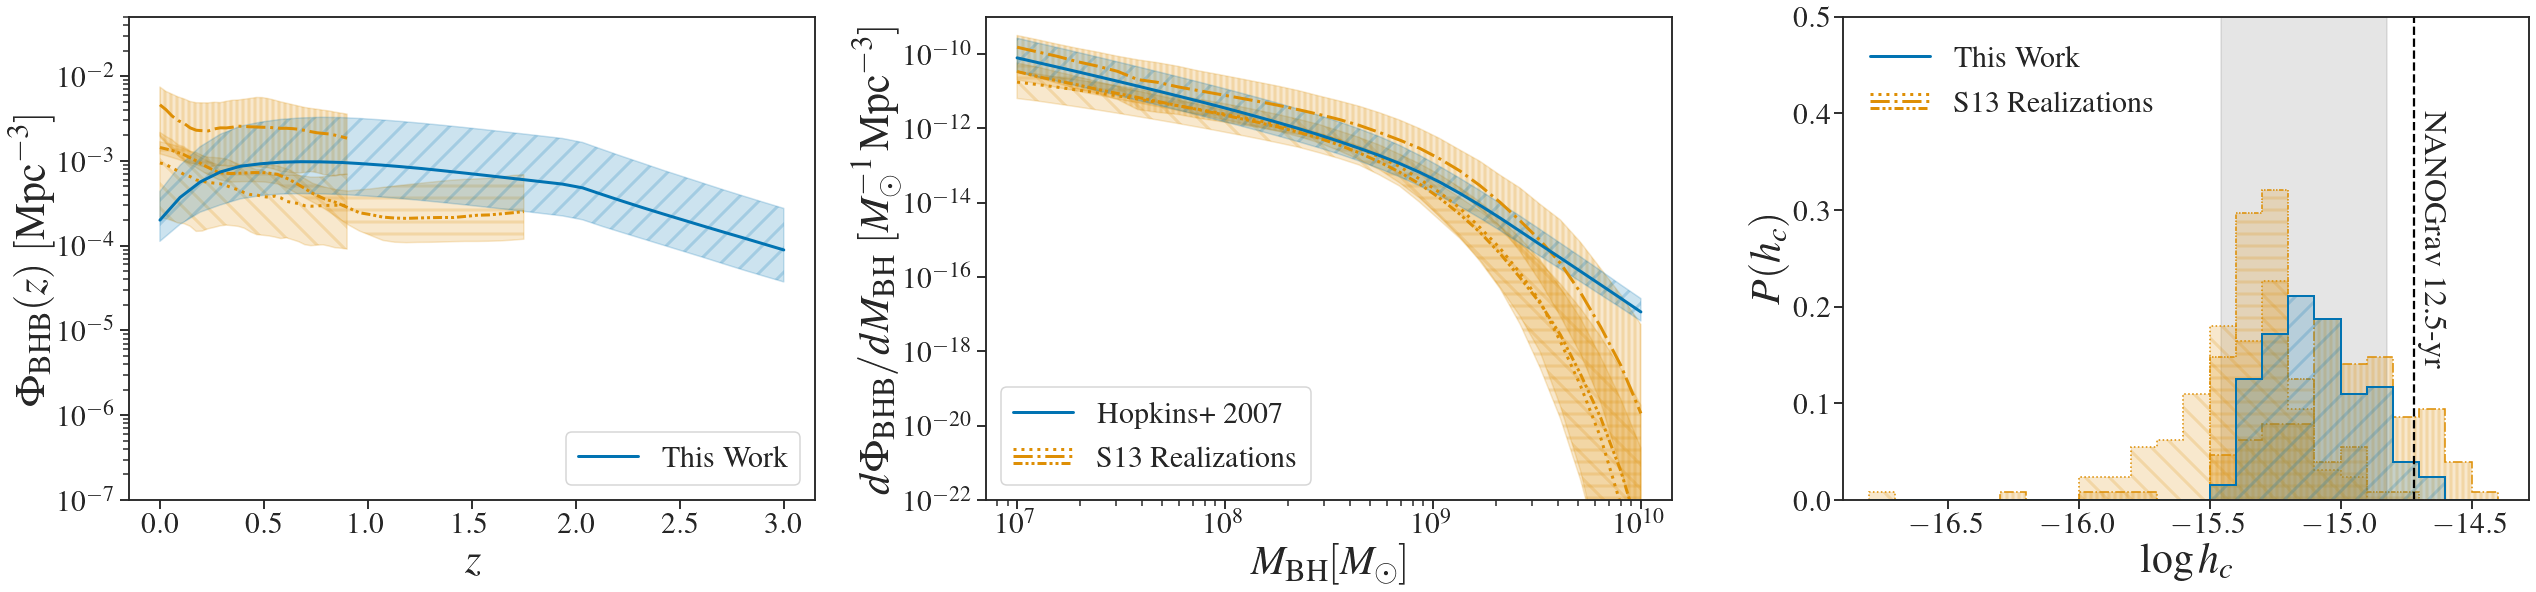

In [117]:
log_nz_i_l_kw_fid_min = np.floor(np.min(np.log10([np.min(differential_number_density_q[1]), np.min(S1_number_density_q[1]),
                                                  np.min(S2_number_density_q[1]), np.min(S3_number_density_q[1])])))
log_nz_i_l_kw_fid_max = np.ceil(np.max(np.log10([np.max(differential_number_density_q[1]), np.max(S1_number_density_q[1]),
                                                 np.max(S2_number_density_q[1]), np.max(S3_number_density_q[1])])))


log_hc_min = np.floor(10 * np.min(np.log10(np.concatenate((hc[-1, -1, -1, :], S1_hc[-1, -1, -1, :],
                                            S2_hc[-1, -1, -1, :], S3_hc[-1, -1, -1, :]))))) / 10
log_hc_max = np.ceil(10 * np.max(np.log10(np.concatenate((hc[-1, -1, -1, :], S1_hc[-1, -1, -1, :],
                                           S2_hc[-1, -1, -1, :], S3_hc[-1, -1, -1, :]))))) / 10
bins = np.linspace(log_hc_min, log_hc_max,
                   int((log_hc_max - (log_hc_min - .1)) / .1))

sesana_min = 3.5e-16
sesana_max = 1.5e-15
log_sesana_min = np.log10(sesana_min)
log_sesana_max = np.log10(sesana_max)
log_sesana_mid = np.mean([log_sesana_min, log_sesana_max])
log_sesana_h = log_sesana_max - log_sesana_mid
log_sesana_l = log_sesana_mid - log_sesana_min

log_hc_mid = np.log10(hc_q[1, -1, -1, -1])
log_hc_min = np.log10(hc_q[0, -1, -1, -1])
log_hc_max = np.log10(hc_q[2, -1, -1, -1])
log_hc_h = log_hc_max - log_hc_mid
log_hc_l = log_hc_mid - log_hc_min

sns.set_context("talk", font_scale=1.8)
fig, ax = plt.subplots(1, 3, figsize=(36, 9))

label_fsize = 42
legend_fsize = 30

ax[0].tick_params()
ax[1].tick_params()

ax[0].fill_between(z_range_borch, S1_number_density_q[0], S1_number_density_q[2],
                 color=cs[1], alpha=.2, hatch='\\')
s1, = ax[0].plot(z_range_borch, S1_number_density_q[1], color=cs[1],
                linewidth=3, linestyle=':')
ax[0].fill_between(z_range_drory, S2_number_density_q[0], S2_number_density_q[2],
                 color=cs[1], alpha=.2, hatch='||')
s2, = ax[0].plot(z_range_drory, S2_number_density_q[1], color=cs[1],
                linewidth=3, linestyle='-.')
ax[0].fill_between(z_range_ilbert, S3_number_density_q[0], S3_number_density_q[2],
                 color=cs[1], alpha=.2, hatch='-')
s3, = ax[0].plot(z_range_ilbert, S3_number_density_q[1], color=cs[1],
                linewidth=3, linestyle=(0, (3, 1, 1, 1, 1, 1)))

# ax[0].fill_between(z_range, nz_q[0], nz_q[2], color=cs[2], alpha=.2, hatch='.')
# m2, = ax[0].plot(z_range, nz_q[1], color=cs[2], linewidth=3, linestyle='--')

ax[0].fill_between(z_range, differential_number_density_q[0], differential_number_density_q[2], color=cs[0], alpha=.2, hatch='/')
m1, = ax[0].plot(z_range, differential_number_density_q[1], color=cs[0], linewidth=3, linestyle='-')

ax[0].set_yscale('log')
ax[0].set_ylabel(r'$\Phi_{\rm{BHB}}(z)\ [\rm{Mpc}^{-3}]$', fontsize=label_fsize)
ax[0].set_xlabel(r'$z$', fontsize=label_fsize)
# ax[0].set_ylim((10 ** (log_nz_i_l_kw_fid_min - 1), 10 ** (log_nz_i_l_kw_fid_max + 1)))
ax[0].set_ylim(top=5e-2, bottom=1e-7)

# ax[0].legend([m1, m2, (s1, s2, s3)], ['This Work', 'G19', 'S13 Realizations'], numpoints=1,
#              handler_map={tuple: HandlerTupleVertical(ndivide=None)}, loc='lower right', fontsize=legend_fsize)
ax[0].legend([m1], ['This Work'], numpoints=1,
             handler_map={tuple: HandlerTupleVertical(ndivide=None)}, loc='lower right', fontsize=legend_fsize)

ax[1].fill_between(10 ** log_m_bh_range, S1_local_bhmf_q[0], S1_local_bhmf_q[2], color=cs[1], alpha=.2, hatch='\\')
s1, = ax[1].plot(10 ** log_m_bh_range, S1_local_bhmf_q[1], color=cs[1],
                 linewidth=3, linestyle=':')
ax[1].fill_between(10 ** log_m_bh_range, S2_local_bhmf_q[0], S2_local_bhmf_q[2], color=cs[1], alpha=.2, hatch='||')
s2, = ax[1].plot(10 ** log_m_bh_range, S2_local_bhmf_q[1], color=cs[1],
                 linewidth=3, linestyle='-.')
ax[1].fill_between(10 ** log_m_bh_range, S3_local_bhmf_q[0], S3_local_bhmf_q[2], color=cs[1], alpha=.2, hatch='-')
s3, = ax[1].plot(10 ** log_m_bh_range, S3_local_bhmf_q[1], color=cs[1],
                 linewidth=3, linestyle=(0, (3, 1, 1, 1, 1, 1)))

# ax[1].fill_between(10 ** log_m_bh_range, p_m_q[0], p_m_q[2], color=cs[2], alpha=.2, hatch='.')
# m2, = ax[1].plot(10 ** log_m_bh_range, p_m_q[1], color=cs[2], linewidth=3, linestyle='--')

ax[1].fill_between(10 ** log_m_bh_range, local_bhmf_q[0], local_bhmf_q[2], color=cs[0], alpha=.2, hatch='/')
m1, = ax[1].plot(10 ** log_m_bh_range, local_bhmf_q[1], color=cs[0], linewidth=3, linestyle='-')

ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_ylabel(r'$d \Phi_{\rm{BHB}} / d M_{\rm{BH}}\ [M_{\odot}^{-1}\,\rm{Mpc}^{-3}]$', fontsize=label_fsize)
ax[1].set_xlabel(r'$M_{\rm{BH}} [M_{\odot}]$', fontsize=label_fsize)
ax[1].set_ylim(bottom=1e-22, top=1e-9)
# ax[1].legend([m1, m2, (s1, s2, s3)], ['Hopkins+ 2007', 'Marconi+ 2004', 'S13 Realizations'], numpoints=1,
#              handler_map={tuple: HandlerTupleVertical(ndivide=None)}, loc='lower left', fontsize=legend_fsize)
ax[1].legend([m1, (s1, s2, s3)], ['Hopkins+ 2007', 'S13 Realizations'], numpoints=1,
             handler_map={tuple: HandlerTupleVertical(ndivide=None)}, loc='lower left', fontsize=legend_fsize)

ax[2].axvspan(log_sesana_min, log_sesana_max, color='k', alpha=.1)
ax[2].hist(np.log10(S1_hc[-1, -1, -1, :]), histtype='step', bins=bins,
           density=False, color=cs[1], linestyle=':',
           label=r'S13: Realization 1',
           weights=np.repeat(1 / len(S1_hc[-1, -1, -1, :]), len(S1_hc[-1, -1, -1, :])),
           fill=True, alpha=.2, hatch='\\')
ax[2].hist(np.log10(S1_hc[-1, -1, -1, :]), histtype='step', bins=bins,
           density=False, color=cs[1], linestyle=':',
           label=r'S13: Realization 1',
           weights=np.repeat(1 / len(S1_hc[-1, -1, -1, :]), len(S1_hc[-1, -1, -1, :])))

ax[2].hist(np.log10(S2_hc[-1, -1, -1, :]), histtype='step', bins=bins,
           density=False, color=cs[1], linestyle='-.',
           label=r'S13: Realization 2',
           weights=np.repeat(1 / len(S2_hc[-1, -1, -1, :]), len(S2_hc[-1, -1, -1, :])),
           fill=True, alpha=.2, hatch='||')
ax[2].hist(np.log10(S2_hc[-1, -1, -1, :]), histtype='step', bins=bins,
           density=False, color=cs[1], linestyle='-.',
           label=r'S13: Realization 2',
           weights=np.repeat(1 / len(S2_hc[-1, -1, -1, :]), len(S2_hc[-1, -1, -1, :])))

ax[2].hist(np.log10(S3_hc[-1, -1, -1, :]), histtype='step', bins=bins,
           density=False, color=cs[1], linestyle=(0, (3, 1, 1, 1, 1, 1)),
           label=r'S13: Realization 3',
           weights=np.repeat(1 / len(S3_hc[-1, -1, -1, :]), len(S3_hc[-1, -1, -1, :])),
           fill=True, alpha=.2, hatch='-')
ax[2].hist(np.log10(S3_hc[-1, -1, -1, :]), histtype='step', bins=bins,
           density=False, color=cs[1], linestyle=(0, (3, 1, 1, 1, 1, 1)),
           label=r'S13: Realization 3',
           weights=np.repeat(1 / len(S3_hc[-1, -1, -1, :]), len(S3_hc[-1, -1, -1, :])))

# ax[2].hist(np.log10(hc_g), histtype='step', bins=bins, density=False, color=cs[2], linestyle='--',
#            label=r'G19', weights=np.repeat(1 / len(hc_g), len(hc_g)), linewidth=2, fill=True, alpha=.2, hatch='.')
# ax[2].hist(np.log10(hc_g), histtype='step', bins=bins, density=False, color=cs[2], linestyle='--',
#            label=r'G19', weights=np.repeat(1 / len(hc_g), len(hc_g)), linewidth=2)

ax[2].hist(np.log10(hc[-1, -1, -1, :]), histtype='step', bins=bins, density=False, color=cs[0], linestyle='-',
           label=r'This work', weights=np.repeat(1 / len(hc[-1, -1, -1, :]), len(hc[-1, -1, -1, :])), linewidth=2,
           fill=True, alpha=.2, hatch='/')
ax[2].hist(np.log10(hc[-1, -1, -1, :]), histtype='step', bins=bins, density=False, color=cs[0], linestyle='-',
           label=r'This work', weights=np.repeat(1 / len(hc[-1, -1, -1, :]), len(hc[-1, -1, -1, :])), linewidth=2)

# ax[2].annotate(r'S13',
#                xy=(log_sesana_min - .3, .49))
# ax[2].errorbar(log_hc_mid, 0.45,
#              xerr=[[log_hc_l],
#                    [log_hc_h]],
#              capsize=4, color=cs[0])
# ax[2].annotate(r'This Work',
#                xy=(log_hc_min - .75, .44))

ax[2].axvline(np.log10(1.9e-15), color='k', linestyle='--')
ax[2].annotate(r'NANOGrav 12.5-yr',
               xy=(np.log10(1.9e-15) + .03, .4), xytext=(3, 3),
               textcoords="offset points", rotation_mode='anchor', rotation=-90)
ax[2].set_xlabel(r'$\log h_{c}$', fontsize=label_fsize)
ax[2].set_ylabel(r'$P(h_{c})$', fontsize=label_fsize)
ax[2].set_xlim(left=-16.9)
ax[2].set_ylim(top=.5)
# ax[2].legend([m1, m2, (s1, s2, s3)], ['This Work', 'G19', 'S13 Realizations'], numpoints=1,
#              handler_map={tuple: HandlerTupleVertical(ndivide=None)}, frameon=False, loc='upper left', fontsize=legend_fsize)
ax[2].legend([m1, (s1, s2, s3)], ['This Work', 'S13 Realizations'], numpoints=1,
             handler_map={tuple: HandlerTupleVertical(ndivide=None)}, frameon=False, loc='upper left', fontsize=legend_fsize)

plt.tight_layout()
plt.savefig('../reports/figures/model_comparison.pdf')
plt.show()